**Table of contents**<a id='toc0_'></a>    
- [Import des modules](#toc1_)    
- [Chargement des premières lignes](#toc2_)    
- [Classification des features](#toc3_)    
- [Filtrage des produits accessibles en France](#toc4_)    
  - [Répartition des valeurs tous pays confondus](#toc4_1_)    
  - [Filtrage des produits disponibles en France](#toc4_2_)    
- [Colonnes pertinantes](#toc5_)    
- [Fusion des fichiers](#toc6_)    
- [Supression des doublons](#toc7_)    
- [Analyse des valeurs aberrantes](#toc8_)    
  - [Etat de départ](#toc8_1_)    
  - [fat_100g](#toc8_2_)    
  - [saturated-fat-100g](#toc8_3_)    
  - [carbohydrates_100g](#toc8_4_)    
  - [sugars_100g](#toc8_5_)    
  - [salt_100g](#toc8_6_)    
  - [sodium_100g](#toc8_7_)    
  - [proteins_100g](#toc8_8_)    
  - [Récapitulatif](#toc8_9_)    
  - [Combinaisons](#toc8_10_)    
    - [saturated-fat_100g, fat_100g](#toc8_10_1_)    
    - [carbohydrates_100g, sugars_100g](#toc8_10_2_)    
    - [fat_100g, carbohydrates_100g, proteins_100g, salt_100g](#toc8_10_3_)    
  - [energy-kcal_100g](#toc8_11_)    
  - [Retour sur fat_100g, carbohydrates_100g, proteins_100g, salt_100g](#toc8_12_)    
- [Représentation des données](#toc9_)    
- [Imputation des valeurs manquantes](#toc10_)    
  - [Valeurs quantitatives](#toc10_1_)    
    - [Imputation par classes alimentaires](#toc10_1_1_)    
    - [Imputation par linéarité](#toc10_1_2_)    
- [Correction des erreurs incrustées par imputation](#toc11_)    
- [Imputation par voisinage](#toc12_)    
  - [nutriscore_grade](#toc12_1_)    
  - [pnns_groups_2](#toc12_2_)    
  - [main_category](#toc12_3_)    
- [Imputation par déduction: pnss_groups_1](#toc13_)    
- [Suppression des observations avec valeurs manquantes](#toc14_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Import des modules](#toc0_)

In [1]:
import os
import pandas as pd
import numpy as np
import lib.cleanUtils as cu
from lib.dfInfo import show_cols_repartition
from IPython.display import Markdown as md
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import plotly.graph_objects as go
import plotly.express as px
import itertools

pd.set_option("display.max_columns", None)

working_dir = "working"

import plotly.io as pio
pio.renderers.default='iframe'

if not os.path.exists(working_dir):
    os.mkdir(working_dir)

## <a id='toc2_'></a>[Chargement des premières lignes](#toc0_)

In [2]:
df = pd.read_csv("assets/en.openfoodfacts.org.products.csv", sep="\t", nrows=500000)

/tmp/ipykernel_249787/1371243744.py:1: DtypeWarning:

Columns (0,9,15,24,25,29,30,31,33,49,70) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 200 columns):
 #    Column                                                 Non-Null Count   Dtype  
---   ------                                                 --------------   -----  
 0    code                                                   500000 non-null  object 
 1    url                                                    500000 non-null  object 
 2    creator                                                500000 non-null  object 
 3    created_t                                              500000 non-null  int64  
 4    created_datetime                                       500000 non-null  object 
 5    last_modified_t                                        500000 non-null  int64  
 6    last_modified_datetime                                 500000 non-null  object 
 7    last_modified_by                                       486743 non-null  object 
 8    product_name          

In [4]:
df.describe(include="all")

code                                                url  creator  \
count   500000.0                                             500000   500000   
unique  499995.0                                             499999     2523   
top       2216.0  http://world-en.openfoodfacts.org/product/0326...  kiliweb   
freq         2.0                                                  2   230861   
mean         NaN                                                NaN      NaN   
std          NaN                                                NaN      NaN   
min          NaN                                                NaN      NaN   
25%          NaN                                                NaN      NaN   
50%          NaN                                                NaN      NaN   
75%          NaN                                                NaN      NaN   
max          NaN                                                NaN      NaN   

           created_t      created_datetime  last_modified_t  \
count   5.000000e+05                500000     5.000000e+05   
unique           NaN                356378              NaN   
top              NaN  2020-04-23T18:23:21Z              NaN   
freq             NaN                    27              NaN   
mean    1.581277e+09                   NaN     1.620249e+09   
std     6.409202e+07                   NaN     4.101803e+07   
min     1.332445e+09                   NaN     1.415653e+09   
25%     1.520436e+09                   NaN     1.587635e+09   
50%     1.587664e+09                   NaN     1.624910e+09   
75%     1.641785e+09                   NaN     1.659358e+09   
max     1.674524e+09                   NaN     1.674524e+09   

       last_modified_datetime   last_modified_by     product_name  \
count                  500000             486743           490428   
unique                 353184               2226           318673   
top      2022-08-01T12:48:51Z  org-database-usda  Filet de poulet   
freq                      108             158351              571   
mean                      NaN                NaN              NaN   
std                       NaN                NaN              NaN   
min                       NaN                NaN              NaN   
25%                       NaN                NaN              NaN   
50%                       NaN                NaN              NaN   
75%                       NaN                NaN              NaN   
max                       NaN                NaN              NaN   

         abbreviated_product_name generic_name quantity packaging  \
count                          16         5915    54967     20461   
unique                         16         4434     8277      4866   
top     Tabasco sriracha 12x256ml    Ice cream    16 oz   Plastic   
freq                            1          138     3521      1027   
mean                          NaN          NaN      NaN       NaN   
std                           NaN          NaN      NaN       NaN   
min                           NaN          NaN      NaN       NaN   
25%                           NaN          NaN      NaN       NaN   
50%                           NaN          NaN      NaN       NaN   
75%                           NaN          NaN      NaN       NaN   
max                           NaN          NaN      NaN       NaN   

       packaging_tags packaging_en             packaging_text   brands  \
count           20460        20460                        350   228882   
unique           3827         3817                        291    30443   
top        en:plastic      Plastic  1 pot en verre à recycler  Bonarea   
freq             2391         2392                          7    10083   
mean              NaN          NaN                        NaN      NaN   
std               NaN          NaN                        NaN      NaN   
min               NaN          NaN                        NaN      NaN   
25%               NaN          NaN          

## <a id='toc3_'></a>[Classification des features](#toc0_)

On peut dès à présent classer les variables de notre dataframe:

In [5]:
types = dict(zip(df.columns, df.dtypes))

out = "| Variables catégorielles | Variables quantitatives |\n"
out += "|----------|----------|\n"
var_cat = []
var_quant = []
dtypes = {}
for t in types:
    if types[t] == "object":
        var_cat.append(t)
        dtypes[t] = "str"
    elif types[t] == "int64":
        var_quant.append(t)
        dtypes[t] = "int64"
    elif types[t] == "float64":
        var_quant.append(t)
        dtypes[t] = "float64"

for i in range(0, max(len(var_quant), len(var_cat))):
    out += "| "
    if i < len(var_cat):
        out += var_cat[i]
    out += " | "
    if i < len(var_quant):
        out += var_quant[i]
    out += " |\n"

display(md(out))

| Variables catégorielles | Variables quantitatives |
|----------|----------|
| code | created_t |
| url | last_modified_t |
| creator | cities |
| created_datetime | allergens_en |
| last_modified_datetime | serving_quantity |
| last_modified_by | additives_n |
| product_name | additives |
| abbreviated_product_name | nutriscore_score |
| generic_name | nova_group |
| quantity | ecoscore_score |
| packaging | product_quantity |
| packaging_tags | unique_scans_n |
| packaging_en | completeness |
| packaging_text | last_image_t |
| brands | energy-kj_100g |
| brands_tags | energy-kcal_100g |
| categories | energy_100g |
| categories_tags | energy-from-fat_100g |
| categories_en | fat_100g |
| origins | saturated-fat_100g |
| origins_tags | butyric-acid_100g |
| origins_en | caproic-acid_100g |
| manufacturing_places | caprylic-acid_100g |
| manufacturing_places_tags | capric-acid_100g |
| labels | lauric-acid_100g |
| labels_tags | myristic-acid_100g |
| labels_en | palmitic-acid_100g |
| emb_codes | stearic-acid_100g |
| emb_codes_tags | arachidic-acid_100g |
| first_packaging_code_geo | behenic-acid_100g |
| cities_tags | lignoceric-acid_100g |
| purchase_places | cerotic-acid_100g |
| stores | montanic-acid_100g |
| countries | melissic-acid_100g |
| countries_tags | monounsaturated-fat_100g |
| countries_en | polyunsaturated-fat_100g |
| ingredients_text | omega-3-fat_100g |
| ingredients_tags | alpha-linolenic-acid_100g |
| ingredients_analysis_tags | eicosapentaenoic-acid_100g |
| allergens | docosahexaenoic-acid_100g |
| traces | omega-6-fat_100g |
| traces_tags | linoleic-acid_100g |
| traces_en | arachidonic-acid_100g |
| serving_size | gamma-linolenic-acid_100g |
| no_nutrition_data | dihomo-gamma-linolenic-acid_100g |
| additives_tags | omega-9-fat_100g |
| additives_en | oleic-acid_100g |
| nutriscore_grade | elaidic-acid_100g |
| pnns_groups_1 | gondoic-acid_100g |
| pnns_groups_2 | mead-acid_100g |
| food_groups | erucic-acid_100g |
| food_groups_tags | nervonic-acid_100g |
| food_groups_en | trans-fat_100g |
| states | cholesterol_100g |
| states_tags | carbohydrates_100g |
| states_en | sugars_100g |
| brand_owner | added-sugars_100g |
| ecoscore_grade | sucrose_100g |
| nutrient_levels_tags | glucose_100g |
| owner | fructose_100g |
| data_quality_errors_tags | lactose_100g |
| popularity_tags | maltose_100g |
| last_image_datetime | maltodextrins_100g |
| main_category | starch_100g |
| main_category_en | polyols_100g |
| image_url | erythritol_100g |
| image_small_url | fiber_100g |
| image_ingredients_url | soluble-fiber_100g |
| image_ingredients_small_url | insoluble-fiber_100g |
| image_nutrition_url | proteins_100g |
| image_nutrition_small_url | casein_100g |
|  | serum-proteins_100g |
|  | nucleotides_100g |
|  | salt_100g |
|  | added-salt_100g |
|  | sodium_100g |
|  | alcohol_100g |
|  | vitamin-a_100g |
|  | beta-carotene_100g |
|  | vitamin-d_100g |
|  | vitamin-e_100g |
|  | vitamin-k_100g |
|  | vitamin-c_100g |
|  | vitamin-b1_100g |
|  | vitamin-b2_100g |
|  | vitamin-pp_100g |
|  | vitamin-b6_100g |
|  | vitamin-b9_100g |
|  | folates_100g |
|  | vitamin-b12_100g |
|  | biotin_100g |
|  | pantothenic-acid_100g |
|  | silica_100g |
|  | bicarbonate_100g |
|  | potassium_100g |
|  | chloride_100g |
|  | calcium_100g |
|  | phosphorus_100g |
|  | iron_100g |
|  | magnesium_100g |
|  | zinc_100g |
|  | copper_100g |
|  | manganese_100g |
|  | fluoride_100g |
|  | selenium_100g |
|  | chromium_100g |
|  | molybdenum_100g |
|  | iodine_100g |
|  | caffeine_100g |
|  | taurine_100g |
|  | ph_100g |
|  | fruits-vegetables-nuts_100g |
|  | fruits-vegetables-nuts-dried_100g |
|  | fruits-vegetables-nuts-estimate_100g |
|  | fruits-vegetables-nuts-estimate-from-ingredients_100g |
|  | collagen-meat-protein-ratio_100g |
|  | cocoa_100g |
|  | chlorophyl_100g |
|  | carbon-footprint_100g |
|  | carbon-footprint-from-meat-or-fish_100g |
|  | nutrition-score-fr_100g |
|  | nutrition-score-uk_100g |
|  | glycemic-index_100g |
|  | water-hardness_100g |
|  | choline_100g |
|  | phylloquinone_100g |
|  | beta-glucan_100g |
|  | inositol_100g |
|  | carnitine_100g |


Cependant on constate des erreur au niveau de additives et cities, nous corrigeons manuellement:

In [6]:
dtypes["additives"] = "str"
dtypes["cities"] = "str"

Parmi les variables catégorielles, on remarque certaines qui correspondent à des URL (adresse d'un photo, etc ...). Nous ne prendrons pas ces variables.

In [7]:
other_cols_to_del = []

for i in range(len(df.columns) - 1, -1, -1):
    if df.columns[i].endswith("url"):
        other_cols_to_del.append(df.columns[i])

On remarque aussi des timestamps et des datetime, nous ne les prendrons pas.

In [8]:
for i in range(len(df.columns) - 1, -1, -1):
    if df.columns[i].endswith("datetime") or df.columns[i].endswith("_t"):
        other_cols_to_del.append(df.columns[i])

Il y a aussi des variables semblables:
- packaging, packaging_tags, packaging_en, packaging_text

In [9]:
df.loc[
    ~df["packaging"].isna(),
    ["packaging", "packaging_tags", "packaging_en", "packaging_text"],
]

packaging      packaging_tags       packaging_en  \
31      Plastique, Barquette  en:plastic,en:tray       Plastic,Tray   
72                     Verre            en:glass              Glass   
89            Boîte en métal   fr:boite-en-metal  fr:boite-en-metal   
179         Plastique, Bocal   en:plastic,en:jar        Plastic,Jar   
186                Plastique          en:plastic            Plastic   
...                      ...                 ...                ...   
499609                22 PAP            en:paper              Paper   
499668          Glass bottle     en:glass-bottle       Glass-bottle   
499784                  Pack             en:pack               Pack   
499844               Plastic          en:plastic            Plastic   
499845               Plastic          en:plastic            Plastic   

       packaging_text  
31                NaN  
72                NaN  
89                NaN  
179               NaN  
186               NaN  
...               ...  
499609            NaN  
499668            NaN  
499784            NaN  
499844            NaN  
499845            NaN  

[20461 rows x 4 columns]

Nous allons supprimer les colonnes packaging et packaging_en pour ne garder que packaging_tags

In [10]:
other_cols_to_del = np.concatenate(
    (other_cols_to_del, ["packaging", "packaging_en", "packaging_text"])
)

De manière plus générale, lorqu'une variable se termine par _tags, alors les vrariables commençant par le même préfixe peuvent être ignorées.

In [11]:
other_cols_to_del = other_cols_to_del = np.append(other_cols_to_del, "labels")
other_cols_to_del = np.append(other_cols_to_del, "labels_en")
other_cols_to_del = np.append(other_cols_to_del, "manufacturing_places")
other_cols_to_del = np.append(other_cols_to_del, "emb_codes")
other_cols_to_del = np.append(other_cols_to_del, "countries")
other_cols_to_del = np.append(other_cols_to_del, "countries_en")
other_cols_to_del = np.append(other_cols_to_del, "ingredients_text")
other_cols_to_del = np.append(other_cols_to_del, "traces")
other_cols_to_del = np.append(other_cols_to_del, "traces_en")
other_cols_to_del = np.append(other_cols_to_del, "additives_en")
other_cols_to_del = np.append(other_cols_to_del, "food_groups")
other_cols_to_del = np.append(other_cols_to_del, "food_groups_en")
other_cols_to_del = np.append(other_cols_to_del, "states")
other_cols_to_del = np.append(other_cols_to_del, "states_en")
other_cols_to_del = np.append(other_cols_to_del, "cities")
other_cols_to_del = np.append(other_cols_to_del, "brands")
other_cols_to_del = np.append(other_cols_to_del, "origins")
other_cols_to_del = np.append(other_cols_to_del, "origins_en")
other_cols_to_del = np.append(other_cols_to_del, "categories")
other_cols_to_del = np.append(other_cols_to_del, "categories_en")

## <a id='toc4_'></a>[Filtrage des produits accessibles en France](#toc0_)

In [12]:
df["countries_tags"].unique()

array(['en:france', 'en:germany', 'en:spain', 'en:united-states',
       'en:ireland', nan, 'en:belgium', 'en:united-kingdom',
       'en:france,en:united-states', 'en:germany,en:spain',
       'en:cote-d-ivoire', 'en:canada', 'en:switzerland', 'en:italy',
       'en:belgium,en:france', 'en:peru', 'en:oman', 'en:slovenia',
       'en:france,en:germany', 'en:france,en:germany,en:netherlands',
       'en:kuwait', 'en:belgium,en:germany', 'en:united-arab-emirates',
       'en:france,en:switzerland', 'en:india', 'en:romania',
       'en:australia', 'en:norway', 'en:malaysia', 'en:luxembourg',
       'en:portugal', 'en:mexico', 'en:dominican-republic', 'en:reunion',
       'en:martinique', 'en:germany,en:united-kingdom', 'en:israel',
       'en:netherlands', 'en:puerto-rico', 'en:germany,en:ireland',
       'en:saudi-arabia', 'en:poland', 'en:jamaica', 'en:turkey',
       'en:germany,en:united-states', 'en:bulgaria', 'en:rwanda',
       'en:france,en:united-kingdom',
       'en:belgium,en:f

On voit que les tag sont séparés par des virgules.

On commence par lister les différents pays où sont disponibles les produits avec la fonction extract_nb_terms_from_col qui retournera les noms de pays en minuscules.

Etant donné les limitations matérielles, nous allons procéder par paquets de 300000 observations.

Nous allons en profiter diviser le fichier initial en plusieurs fichiers parquets pour travailler sur ceux-ci au lieu de travailler sur un seul gros fichier.

On calcule aussi le nombre de valeurs remplies dans la même boucle.

In [13]:
skip_rows = 0
nrows = 300000

all_countries = {}
ind = 1
parquet_file_indexes = []
repartition = dict(zip(df.columns, [0] * len(df.columns)))
total_count = 0
while True:
    df = pd.read_csv(
        "assets/en.openfoodfacts.org.products.csv",
        sep="\t",
        dtype=dtypes,
        nrows=nrows,
        skiprows=range(1, total_count),
    )

    if df.shape[0] == 0:
        break
    df.drop(columns=other_cols_to_del, inplace=True)
    parquet_fname = f"{working_dir}/en.openfoodfacts.org.products_{ind}.parquet"
    df.to_parquet(parquet_fname, engine="fastparquet")
    parquet_file_indexes.append(ind)
    countries = cu.extract_nb_terms_from_col(
        df, "countries_tags", sep=[","], min_length=0
    )
    for c2 in countries:
        if not c2 in all_countries:
            all_countries[c2] = 0
        all_countries[c2] += countries[c2]

    for col in df.columns:
        repartition[col] += df.loc[~df[col].isna()].shape[0]
    total_count += df.shape[0]
    ind += 1

### <a id='toc4_1_'></a>[Répartition des valeurs tous pays confondus](#toc0_)

In [14]:
df_info = pd.DataFrame(
    {"column": repartition.keys(), "filled_nb": repartition.values()}
)
df_info["filled_ratio"] = round(100 * df_info["filled_nb"] / total_count, 2)
df_info["dtype"] = df_info.apply(lambda x: dtypes[x["column"]], axis=1)
df_info.to_parquet(f"{working_dir}/repartition_tous_pays.parquet")

fig = px.bar(
    df_info,
    x="filled_ratio",
    y="column",
    orientation="h",
    color="dtype",
    color_discrete_sequence=px.colors.qualitative.G10,
    title="Répartition des variables par nombre d'observations renseignées et par type, tous pays confondus",
    labels={
        "column": "Nom de la colonne",
        "filled_ratio": "Taux de remplissage",
        "dtype": "Type de la variable",
    },
)
fig.update_layout(
    {
        "height": df_info.shape[0] * 2800 / 162,
        "yaxis_categoryorder": "total ascending",
    }
)
fig.update_yaxes(tickfont={"size": 9})

### <a id='toc4_2_'></a>[Filtrage des produits disponibles en France](#toc0_)

Le but étant de ne retenir que les produits disponibles en France, nous allons lister tous les pays notés comportant "fra" ou "fre"

In [15]:
for c in all_countries:
    if "fren" in c or "fran" in c:
        print(c)

en:france
en:french-polynesia
en:francia
en:french-guiana
en:frankreich
en:france-united-states
en:francia-espana
en:polynesie-francaise
en:france-usa
en:france-united-states-en-united-states
en:belgium-francais
en:canada-francais
en:france-francais
en:switzerland-francais
en:france-en-ca
fr:francia
en:francja
en:frankrijk
en:french-southern-and-antarctic-lands
en:andorra-francia-portugal-espana
en:frankreich-deutschland
en:frankrig
en:belgium-france-spain-portugal
en:france-spain
en:frankrike
en:france-switzerland-germany
en:match-france-lille
en:france-germany
en:francia-alemania-espana
en:pays-bas-france
en:belgium-france-slovenia
en:france-en-belgium
en:belgium-france-germany
en:france-etats-unis
en:frankreich-germany
en:francuska
en:belgique-en-france
en:belgique-france
en:france-suisse
en:france-espagne
fr:france🇨🇵🇫🇷
en:polinesia-francesa
en:be-en-france
fr:frankreich
en:spain-france
en:franca-suica-brasil
fr:frankrijk
en:francia-spagna-en-italy
fr:fabrique-en-france
fr:polinesia

On retient les lignes correspondant à la France (non liée avec un autre pays)

In [16]:
from_france_terms = [
    "en:france",
    "en:french-polynesia",
    "en:french-guiana",
    "en:francia",
    "en:frankreich",
    "en:france-francais",
    "en:polynesie-francaise",
    "fr:francia",
    "en:frankrijk",
    "fr:frankreich",
    "fr:polinesia-francesa",
    "fr:francja",
    "en:polinesia-francesa",
    "fr:franța",
    "fr:france🇨🇵🇫🇷",
    "fr:frankrijk",
    "fr:fabrique-en-france",
    "en:francja",
    "fr:paris-france",
    "fr:france🇨🇵",
    "fr:france-only",
    "en:union-europeenne-france",
    "en:franța",
    "fr:franca",
    "en:franca",
    "es:franca",
    "en:frankrig",
    "ca:franca",
    "en:francuzka",
    "en:frankrike",
    "fr:france-🇫🇷",
    "de:frankreic",
]

Définissons une fonction qui pour une observation décidera si le produit est à retenir en fonction de son pays

In [17]:
def product_in_country(x, terms):
    if pd.isna(x["countries_tags"]):
        return False

    for t in terms:
        if str(t) in x["countries_tags"].lower():
            return True

    return False

Nous allons maintenant charger le fichier entier pour le filtrer ensuite.

In [18]:
repartition_fr = dict(zip(df.columns, [0] * len(df.columns)))
total_count_fr = 0
for i in parquet_file_indexes:
    df = pd.read_parquet(f"{working_dir}/en.openfoodfacts.org.products_{i}.parquet")
    print(f"index: {i} before: {df.shape[0]}")
    df["keep"] = df.apply(lambda x: product_in_country(x, from_france_terms), axis=1)
    df.drop(df.loc[df["keep"] == False].index, inplace=True)
    df.drop(columns=["keep"], inplace=True)
    for col in df.columns:
        repartition_fr[col] += df.loc[~df[col].isna()].shape[0]
    total_count_fr += df.shape[0]

    print(f"index: {i} after: {df.shape[0]}")
    df.to_parquet(f"{working_dir}/in_france_products_{i}.parquet")

index: 1 before: 300000
index: 1 after: 15778
index: 2 before: 300000
index: 2 after: 70050
index: 3 before: 300000
index: 3 after: 73919
index: 4 before: 300000
index: 4 after: 228929
index: 5 before: 300000
index: 5 after: 282938
index: 6 before: 300000
index: 6 after: 65058
index: 7 before: 300000
index: 7 after: 90711
index: 8 before: 300000
index: 8 after: 58539
index: 9 before: 300000
index: 9 after: 63215
index: 10 before: 32771
index: 10 after: 5476


In [19]:
df_info_fr = pd.DataFrame(
    {"column": repartition_fr.keys(), "filled_nb": repartition_fr.values()}
)
df_info_fr["filled_ratio"] = round(100 * df_info_fr["filled_nb"] / total_count_fr, 2)
df_info_fr["dtype"] = df_info_fr.apply(lambda x: dtypes[x["column"]], axis=1)
df_info_fr.to_parquet(f"{working_dir}/repartition_france.parquet")

fig = px.bar(
    df_info_fr,
    x="filled_ratio",
    y="column",
    orientation="h",
    color="dtype",
    color_discrete_sequence=px.colors.qualitative.G10,
    title="Répartition des variables par nombre d'observations renseignées et par type, pour la France",
    labels={
        "column": "Nom de la colonne",
        "filled_ratio": "Taux de remplissage",
        "dtype": "Type de la variable",
    },
)
fig.update_layout(
    {
        "height": df_info_fr.shape[0] * 2800 / 162,
        "yaxis_categoryorder": "total ascending",
    }
)
fig.update_yaxes(tickfont={"size": 9})

## <a id='toc5_'></a>[Colonnes pertinantes](#toc0_)

Au vu de la répartition des données, nous allons imaginer une appplication qui donne un grade de nutricscore, même pour les produits non gradés.

Pour cela, nous allons utiliser les variables catégorielles qui permettent de classer les produits selon leur type, grade:
- pnns_groups_1
- pnns_groups_2
- main_category
- food_groups_tags

Nous allons aussi garder les variables catégorielles identifiant les produits:
- code
- product_name
- brands_tags

Nous allons garder les variables quantitatives qui sont remplies à au mois 50%.



In [20]:
keep_columns = [
    "pnns_groups_1",
    "pnns_groups_2",
    "main_category",
    "food_groups_tags",
    "code",
    "product_name",
    "brands_tags",
    "nutriscore_score",
    "nutriscore_grade",
]
for c in df_info_fr.loc[
    ((df_info_fr["dtype"] == "int64") | (df_info_fr["dtype"] == "float64"))
    & (df_info_fr["filled_ratio"] >= 50)
]["column"]:
    keep_columns.append(c)

In [21]:
drop_columns = []
for i in range(0, len(df.columns)):
    if not df.columns[i] in keep_columns:
        drop_columns.append(df.columns[i])

In [22]:
for i in parquet_file_indexes:
    df = pd.read_parquet(f"{working_dir}/in_france_products_{i}.parquet")
    df.drop(columns=drop_columns, inplace=True)
    df.to_parquet(f"{working_dir}/in_france_trimmed_products_{i}.parquet")

## <a id='toc6_'></a>[Fusion des fichiers](#toc0_)

In [23]:
df = pd.read_parquet(f"{working_dir}/in_france_trimmed_products_1.parquet")
for i in parquet_file_indexes:
    if i == 1:
        continue
    df2 = pd.read_parquet(f"{working_dir}/in_france_trimmed_products_{i}.parquet")
    df = pd.concat([df, df2])

In [24]:
df.reset_index(drop=True, inplace=True)

In [25]:
df.shape

(954613, 19)

In [26]:
df

code                  product_name    brands_tags  \
0          00000000000000225                jeunes pousses        endives   
1       00000000000026772226                          Skyr         danone   
2              0000000000017              Vitória crackers           None   
3              0000000000031                         Cacao           None   
4              0000000000100   moutarde au moût de raisin   courte-paille   
...                      ...                           ...            ...   
954608         9999999004360                Minis beignets           None   
954609              99999995                Steak haché 5%           None   
954610             999999999       Thé noir BIO Darjeeling          pages   
954611         9999999999994     Light & Free SKYR A BOIRE           None   
954612       999999999999999             Signal Toothpaste           None   

        nutriscore_score nutriscore_grade            pnns_groups_1  \
0                    NaN             None                  unknown   
1                   -5.0                a  Milk and dairy products   
2                    NaN             None                  unknown   
3                    NaN             None                  unknown   
4                   18.0                d           Fat and sauces   
...                  ...              ...                      ...   
954608              15.0                d                  unknown   
954609              -2.0                a           Fish Meat Eggs   
954610               NaN             None                  unknown   
954611              25.0                e  Milk and dairy products   
954612               NaN             None                  unknown   

               pnns_groups_2  \
0                    unknown   
1             Dairy desserts   
2                    unknown   
3                    unknown   
4       Dressings and sauces   
...                      ...   
954608               unknown   
954609                  Meat   
954610               unknown   
954611        Dairy desserts   
954612               unknown   

                                         food_groups_tags  completeness  \
0                                                    None        0.2000   
1            en:milk-and-dairy-products,en:dairy-desserts        0.5750   
2                                                    None        0.2750   
3                                                    None        0.2625   
4              en:fats-and-sauces,en:dressings-and-sauces        0.7625   
...                                                   ...           ...   
954608                                               None        0.3750   
954609  en:fish-meat-eggs,en:meat,en:meat-other-than-p...        0.4750   
954610                                               None        0.2000   
954611       en:milk-and-dairy-products,en:dairy-desserts        0.3750   
954612                                               None        0.2625   

            main_category  energy-kcal_100g  energy_100g  fat_100g  \
0                    None               NaN          NaN       NaN   
1        en:cream-cheeses              57.0        238.0       0.2   
2                    None             375.0       1569.0       7.0   
3                    None               NaN          NaN       NaN   
4            en:groceries               NaN        936.0       8.2   
...                   ...               ...          ...       ...   
954608  en:sweet-fritters             333.0       1393.0      20.2   
954609         en:viandes             131.0        548.0       5.0   
954610               None               NaN          NaN       NaN   
954611  en:dairy-desserts              24.0        100.0      28.0   
954612      en:toothpaste               NaN          NaN       NaN   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0                      NaN                 NaN       

Nous remarquons des valeurs "unknown" pour les variables "pnns_groups_1" et pnns_groups2".

In [27]:
print(df.loc[df["pnns_groups_1"].str.lower().str.strip()=="unknown"].shape)
print(df.loc[df["pnns_groups_2"].str.lower().str.strip()=="unknown"].shape)


(551259, 19)
(551259, 19)


In [28]:
df.loc[df["pnns_groups_1"].str.lower().str.strip()=="unknown", "pnns_groups_1"] = None
df.loc[df["pnns_groups_2"].str.lower().str.strip()=="unknown", "pnns_groups_2"] = None

In [29]:
df.head()

code                  product_name    brands_tags  \
0     00000000000000225                jeunes pousses        endives   
1  00000000000026772226                          Skyr         danone   
2         0000000000017              Vitória crackers           None   
3         0000000000031                         Cacao           None   
4         0000000000100   moutarde au moût de raisin   courte-paille   

   nutriscore_score nutriscore_grade            pnns_groups_1  \
0               NaN             None                     None   
1              -5.0                a  Milk and dairy products   
2               NaN             None                     None   
3               NaN             None                     None   
4              18.0                d           Fat and sauces   

          pnns_groups_2                              food_groups_tags  \
0                  None                                          None   
1        Dairy desserts  en:milk-and-dairy-products,en:dairy-desserts   
2                  None                                          None   
3                  None                                          None   
4  Dressings and sauces    en:fats-and-sauces,en:dressings-and-sauces   

   completeness     main_category  energy-kcal_100g  energy_100g  fat_100g  \
0        0.2000              None               NaN          NaN       NaN   
1        0.5750  en:cream-cheeses              57.0        238.0       0.2   
2        0.2750              None             375.0       1569.0       7.0   
3        0.2625              None               NaN          NaN       NaN   
4        0.7625      en:groceries               NaN        936.0       8.2   

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0                 NaN                 NaN          NaN            NaN   
1                0.10                 3.9          3.9           10.0   
2                3.08                70.1         15.0            7.8   
3                 NaN                 NaN          NaN            NaN   
4                2.20                29.0         22.0            5.1   

   salt_100g  sodium_100g  
0        NaN          NaN  
1       0.09        0.036  
2       1.40        0.560  
3        NaN          NaN  
4       4.60        1.840

In [30]:
df.describe(include="all")

code     product_name brands_tags  nutriscore_score  \
count          954613           928633      503217     352918.000000   
unique         954597           616783       67149               NaN   
top     0326496301163  Filet de poulet   carrefour               NaN   
freq                2             1032       12534               NaN   
mean              NaN              NaN         NaN          9.482625   
std               NaN              NaN         NaN          8.667834   
min               NaN              NaN         NaN        -15.000000   
25%               NaN              NaN         NaN          2.000000   
50%               NaN              NaN         NaN         10.000000   
75%               NaN              NaN         NaN         16.000000   
max               NaN              NaN         NaN         40.000000   

       nutriscore_grade  pnns_groups_1 pnns_groups_2  \
count            352918         403088        403090   
unique                5             11            41   
top                   d  Sugary snacks        Sweets   
freq             111444          83871         37480   
mean                NaN            NaN           NaN   
std                 NaN            NaN           NaN   
min                 NaN            NaN           NaN   
25%                 NaN            NaN           NaN   
50%                 NaN            NaN           NaN   
75%                 NaN            NaN           NaN   
max                 NaN            NaN           NaN   

                  food_groups_tags   completeness main_category  \
count                       404576  954612.000000        463718   
unique                          46            NaN         21082   
top     en:sugary-snacks,en:sweets            NaN  en:groceries   
freq                         37469            NaN         22258   
mean                           NaN       0.465553           NaN   
std                            NaN       0.238742           NaN   
min                            NaN       0.050000           NaN   
25%                            NaN       0.275000           NaN   
50%                            NaN       0.375000           NaN   
75%                            NaN       0.587500           NaN   
max                            NaN       1.100000           NaN   

        energy-kcal_100g   energy_100g       fat_100g  saturated-fat_100g  \
count      713876.000000  7.370360e+05  730735.000000       735694.000000   
unique               NaN           NaN            NaN                 NaN   
top                  NaN           NaN            NaN                 NaN   
freq                 NaN           NaN            NaN                 NaN   
mean          276.225973  1.182335e+03      14.217488            5.401104   
std           204.440639  2.495907e+04      17.727103           12.862906   
min             0.000000  0.000000e+00      -2.000000            0.000000   
25%           111.000000  4.640000e+02       1.000000            0.200000   
50%           263.000000  1.092000e+03       8.000000            2.000000   
75%           400.000000  1.674000e+03      22.000000            8.000000   
max         31000.000000  2.138214e+07    1386.666667         8569.000000   

        carbohydrates_100g    sugars_100g  proteins_100g      salt_100g  \
count        730823.000000  735403.000000  732598.000000  694630.000000   
unique                 NaN            NaN            NaN            NaN   
top                    NaN            NaN            NaN            NaN   
freq                   NaN            NaN            NaN            NaN   
mean             27.012652      13.576136       8.891057       1.311575   
std              28.616613      20.427907      10.351641      11.771239   
min               0.000000      -0.100000     -19.000000       0.000000   
25%               2.600000       0.600000       1.500000       0.070000   
50%              14.000000       3.400000       6.200000       0.546000   

Notre travail va aussi se baser sur la variable product_name. Voyons si celle-ci est toujours remplie.

In [31]:
df.loc[df["product_name"].isna() | (df["product_name"].str.strip()=="")].shape

(25981, 19)

On supprime les produits sans nom.

In [32]:
df.drop(df.loc[(df["product_name"].isna()) | (df["product_name"].str.strip()=="")].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [33]:
df.to_parquet(f"{working_dir}/trimmed.parquet")

## <a id='toc7_'></a>[Supression des doublons](#toc0_)


In [34]:
df = pd.read_parquet(f"{working_dir}/trimmed.parquet")

In [35]:
df.describe(include="all")

code     product_name brands_tags  nutriscore_score  \
count          928632           928632      495183     351390.000000   
unique         928618           616782       66543               NaN   
top     3560070278831  Filet de poulet   carrefour               NaN   
freq                2             1032       11749               NaN   
mean              NaN              NaN         NaN          9.477427   
std               NaN              NaN         NaN          8.666890   
min               NaN              NaN         NaN        -15.000000   
25%               NaN              NaN         NaN          2.000000   
50%               NaN              NaN         NaN         10.000000   
75%               NaN              NaN         NaN         16.000000   
max               NaN              NaN         NaN         40.000000   

       nutriscore_grade  pnns_groups_1 pnns_groups_2  \
count            351390         400994        400996   
unique                5             11            40   
top                   d  Sugary snacks        Sweets   
freq             110923          83369         37268   
mean                NaN            NaN           NaN   
std                 NaN            NaN           NaN   
min                 NaN            NaN           NaN   
25%                 NaN            NaN           NaN   
50%                 NaN            NaN           NaN   
75%                 NaN            NaN           NaN   
max                 NaN            NaN           NaN   

                  food_groups_tags   completeness main_category  \
count                       402475  928632.000000        460631   
unique                          46            NaN         20844   
top     en:sugary-snacks,en:sweets            NaN  en:groceries   
freq                         37258            NaN         22130   
mean                           NaN       0.474142           NaN   
std                            NaN       0.234771           NaN   
min                            NaN       0.100000           NaN   
25%                            NaN       0.275000           NaN   
50%                            NaN       0.375000           NaN   
75%                            NaN       0.587500           NaN   
max                            NaN       1.100000           NaN   

        energy-kcal_100g   energy_100g       fat_100g  saturated-fat_100g  \
count      711062.000000  7.340270e+05  727787.000000       732762.000000   
unique               NaN           NaN            NaN                 NaN   
top                  NaN           NaN            NaN                 NaN   
freq                 NaN           NaN            NaN                 NaN   
mean          276.202693  1.182380e+03      14.217128            5.402000   
std           204.474837  2.501012e+04      17.729569           12.880188   
min             0.000000  0.000000e+00      -2.000000            0.000000   
25%           111.000000  4.640000e+02       1.000000            0.200000   
50%           263.000000  1.091000e+03       8.000000            2.000000   
75%           400.000000  1.674000e+03      22.000000            8.000000   
max         31000.000000  2.138214e+07    1386.666667         8569.000000   

        carbohydrates_100g    sugars_100g  proteins_100g      salt_100g  \
count        727877.000000  732463.000000  729640.000000  691721.000000   
unique                 NaN            NaN            NaN            NaN   
top                    NaN            NaN            NaN            NaN   
freq                   NaN            NaN            NaN            NaN   
mean             27.004101      13.573099       8.891190       1.309643   
std              28.616075      20.428532      10.355103      11.767715   
min               0.000000      -0.100000     -19.000000       0.000000   
25%               2.600000       0.600000       1.500000       0.070000   
50%              14.000000       3.400000       6.200000       0.546000   

On remarque d'emblée qu'il y a des doublons au niveau des codes. Nous allons fusionner ces différents doublons: 
1. on cherche les doublons au niveau des paires codes/product_name
2. on utilise la fonction deduplicate sur les groupes basés sur les doublons

In [36]:
doublons = (
    df.assign(nb=1)
    .groupby(["product_name", "code"])
    .sum("nb")
    .reset_index()
    .query("nb>1")
    .loc[:, ["product_name", "code", "nb"]]
    .sort_values("nb", ascending=False)
    .reset_index(drop=True)
)
print(f"Nombre de doublons:{doublons.shape[0]}")

Nombre de doublons:13


In [37]:
df["to_remove"] = False

i = 1
for ind in doublons.index:
    print(f"{i}/{doublons.shape[0]} ind={ind}")
    p = doublons.iloc[ind]["product_name"]
    b = doublons.iloc[ind]["code"]
    duplicated_indexes = df.loc[
        (df["product_name"] == p) & (df["code"] == b)
    ].index
    indexes_to_remove = cu.deduplicate(
        df=df,
        grouped_columns=["product_name", "code"],
        duplicated_indexes=duplicated_indexes,
        remove_doublons=False,
    )
    df.loc[indexes_to_remove, "to_remove"] = True
    i += 1
df = df.loc[df["to_remove"] == False]
df.drop(columns=["to_remove"], inplace=True)
df.reset_index(drop=True, inplace=True)


1/13 ind=0
2/13 ind=1
3/13 ind=2
4/13 ind=3
5/13 ind=4
6/13 ind=5
7/13 ind=6
8/13 ind=7
9/13 ind=8
10/13 ind=9
11/13 ind=10
12/13 ind=11
13/13 ind=12


Nous cherchons aussi les doublons au niveau des paires product_name, brands_tags

In [38]:
doublons = (
    df.assign(nb=1)
    .groupby(["product_name", "brands_tags"])
    .sum("nb")
    .reset_index()
    .query("nb>1")
    .loc[:, ["product_name", "brands_tags", "nb"]]
    .sort_values("nb", ascending=False)
    .reset_index(drop=True)
)
print(f"Nombre de doublons:{doublons.shape[0]}")

Nombre de doublons:22956


Nous allons appeler la fonction deduplicate pour chacun de ces doublons

In [39]:
df["to_remove"] = False

i = 1
for ind in doublons.index:
    if i % 100:
        print(f"{i}/{doublons.shape[0]} ind={ind}")
    p = doublons.iloc[ind]["product_name"]
    b = doublons.iloc[ind]["brands_tags"]
    duplicated_indexes = df.loc[
        (df["product_name"] == p) & (df["brands_tags"] == b)
    ].index
    indexes_to_remove = cu.deduplicate(
        df=df,
        grouped_columns=["product_name", "brands_tags"],
        duplicated_indexes=duplicated_indexes,
        remove_doublons=False,
    )
    df.loc[indexes_to_remove, "to_remove"] = True
    i += 1
df = df.loc[df["to_remove"] == False]
df.drop(columns=["to_remove"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_parquet(f"{working_dir}/deduplicated.parquet")

1/22956 ind=0
2/22956 ind=1
3/22956 ind=2
4/22956 ind=3
5/22956 ind=4
6/22956 ind=5
7/22956 ind=6
8/22956 ind=7
9/22956 ind=8
10/22956 ind=9
11/22956 ind=10
12/22956 ind=11
13/22956 ind=12
14/22956 ind=13
15/22956 ind=14
16/22956 ind=15
17/22956 ind=16
18/22956 ind=17
19/22956 ind=18
20/22956 ind=19
21/22956 ind=20
22/22956 ind=21
23/22956 ind=22
24/22956 ind=23
25/22956 ind=24
26/22956 ind=25
27/22956 ind=26
28/22956 ind=27
29/22956 ind=28
30/22956 ind=29
31/22956 ind=30
32/22956 ind=31
33/22956 ind=32
34/22956 ind=33
35/22956 ind=34
36/22956 ind=35
37/22956 ind=36
38/22956 ind=37
39/22956 ind=38
40/22956 ind=39
41/22956 ind=40
42/22956 ind=41
43/22956 ind=42
44/22956 ind=43
45/22956 ind=44
46/22956 ind=45
47/22956 ind=46
48/22956 ind=47
49/22956 ind=48
50/22956 ind=49
51/22956 ind=50
52/22956 ind=51
53/22956 ind=52
54/22956 ind=53
55/22956 ind=54
56/22956 ind=55
57/22956 ind=56
58/22956 ind=57
59/22956 ind=58
60/22956 ind=59
61/22956 ind=60
62/22956 ind=61
63/22956 ind=62
64/22956 in

## <a id='toc8_'></a>[Analyse des valeurs aberrantes](#toc0_)

### <a id='toc8_1_'></a>[Etat de départ](#toc0_)

In [40]:
df = pd.read_parquet(f"{working_dir}/deduplicated.parquet")
df.describe(include="all")

code product_name brands_tags  nutriscore_score  \
count              884375       884375      450930     329274.000000   
unique             884375       616782       66543               NaN   
top     00000000000000225         Miel      auchan               NaN   
freq                    1          756        9563               NaN   
mean                  NaN          NaN         NaN          9.566914   
std                   NaN          NaN         NaN          8.653807   
min                   NaN          NaN         NaN        -15.000000   
25%                   NaN          NaN         NaN          2.000000   
50%                   NaN          NaN         NaN         11.000000   
75%                   NaN          NaN         NaN         16.000000   
max                   NaN          NaN         NaN         40.000000   

       nutriscore_grade  pnns_groups_1 pnns_groups_2  \
count            329274         375193        375194   
unique                5             11            40   
top                   d  Sugary snacks        Sweets   
freq             104202          79752         35483   
mean                NaN            NaN           NaN   
std                 NaN            NaN           NaN   
min                 NaN            NaN           NaN   
25%                 NaN            NaN           NaN   
50%                 NaN            NaN           NaN   
75%                 NaN            NaN           NaN   
max                 NaN            NaN           NaN   

                  food_groups_tags   completeness main_category  \
count                       376628  884375.000000        432049   
unique                          46            NaN         20450   
top     en:sugary-snacks,en:sweets            NaN  en:groceries   
freq                         35473            NaN         20873   
mean                           NaN       0.468373           NaN   
std                            NaN       0.234576           NaN   
min                            NaN       0.100000           NaN   
25%                            NaN       0.275000           NaN   
50%                            NaN       0.375000           NaN   
75%                            NaN       0.587500           NaN   
max                            NaN       1.100000           NaN   

        energy-kcal_100g   energy_100g       fat_100g  saturated-fat_100g  \
count      677644.000000  6.985640e+05  692631.000000       697603.000000   
unique               NaN           NaN            NaN                 NaN   
top                  NaN           NaN            NaN                 NaN   
freq                 NaN           NaN            NaN                 NaN   
mean          276.937135  1.186927e+03      14.234641            5.394840   
std           204.895269  2.563569e+04      17.706091           13.071417   
min             0.000000  0.000000e+00      -2.000000            0.000000   
25%           112.000000  4.690000e+02       1.000000            0.200000   
50%           264.000000  1.096000e+03       8.100000            2.000000   
75%           400.000000  1.674000e+03      22.000000            8.000000   
max         31000.000000  2.138214e+07    1386.666667         8569.000000   

        carbohydrates_100g    sugars_100g  proteins_100g      salt_100g  \
count        692678.000000  697113.000000  694334.000000  658009.000000   
unique                 NaN            NaN            NaN            NaN   
top                    NaN            NaN            NaN            NaN   
freq                   NaN            NaN            NaN            NaN   
mean             27.287071      13.676461       8.779822       1.319372   
std              28.665296      20.491829      10.291391      12.005353   
min               0.000000       0.000000     -19.000000       0.000000   
25%               2.800000       0.600000       1.500000       0.060000   
50%              14.200000       3.500000       6.200000       0.540000   
75%

On remarque que hormis pour la colonne energy_100g, les colonnes présentes se terminant par _100g correspondent à la masse du composant correspondant pour 100g de produit total. 

La valeur doit donc être comprise entre 0 et 100.

Or nous voyons certaines de ces colonnes ont une valeur en dehors de ces limites. Examinons ces valeurs aberrantes.

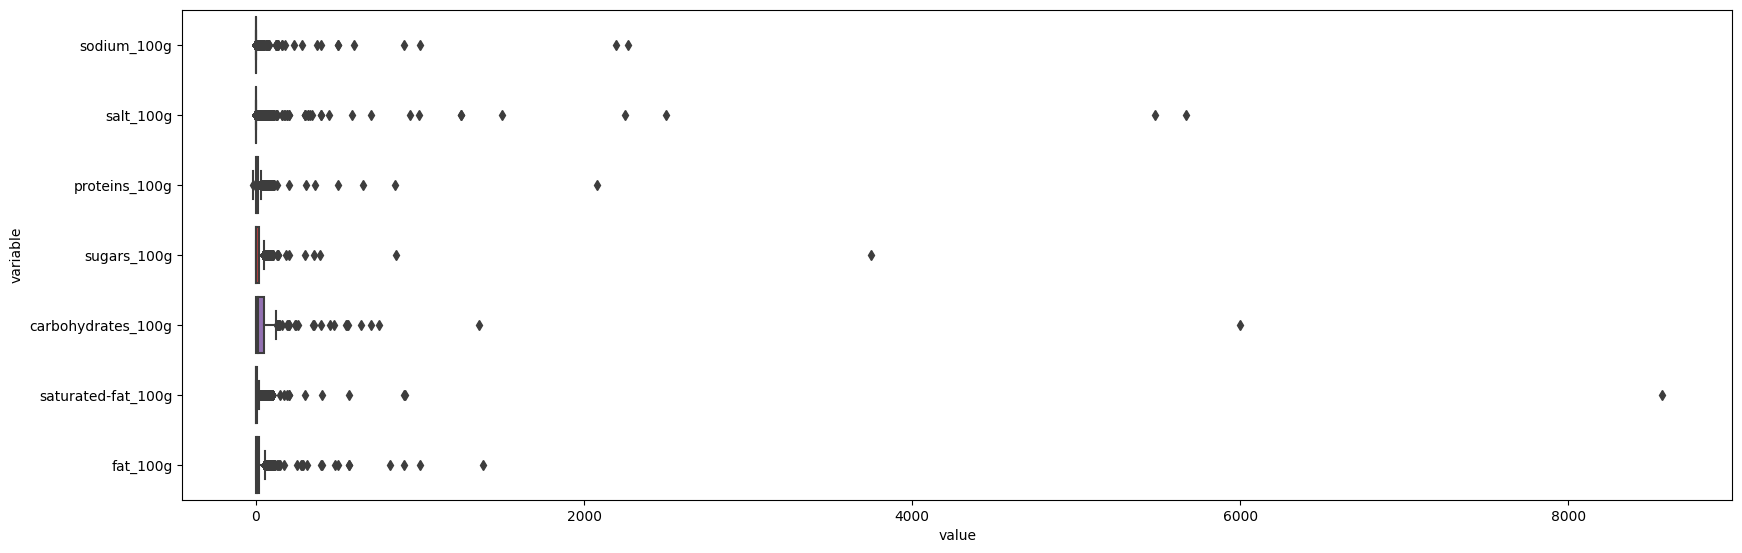

In [41]:
cols = ["fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g"]
show_cols_repartition(df, cols)

### <a id='toc8_2_'></a>[fat_100g](#toc0_)

In [42]:
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)].shape

(28, 19)

In [43]:
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)]

code                                   product_name  \
9533    0051500253625                      Crisco Pure Vegetable Oil   
66230   0303375521850              Organic Hummus Roasted Red Pepper   
67263   0344000040476                                        Cadbury   
69786   0602652171840           Cinnamon Oat Granola with Flax Seeds   
98199   2000000049786                    Dej viennoise Pêche Choc x4   
192494  3000000004784                         Galette du pays basque   
196022  3018170403481              Chipolatas supérieures au basilic   
223418  3121774269398                               Haché végétarien   
226544  3155251205500                      Beurre doux gastronomique   
227107  3160920503207                                         IADSP3   
254083         323168   Aiguillettes de poulet au miel et aux épices   
298633  3263855405018                                 Semoule de blé   
404378  3439495903812                                Saint Marcellin   
436511  3523850964119                          Coffee frap Starbucks   
485293  3599010074035              Cheddar and bacon free range eggs   
494631  3662072014926                                       CLA 1000   
512853  3700442606088                                  Crunchy Melts   
517272  3700662751254                             Mi navette lavande   
579871  3760225201541  Huile d’olive vierge extra extraction à froid   
602326  3770004029013                          Mayonnaise artisanale   
605480  3770007227010                     Huile d'Olive extra vierge   
618225  3770022839007                            Protéine. Végétales   
618489  3770024547085                                        Tapioca   
656845  4316268518949                             Mangos in Scheiben   
717259  5601009927128                                         Salame   
732760  6111037000155                                         Magdor   
736291  6191480200074                     Huile d'olive extra vierge   
740716        6823903                                           Yuka   

                       brands_tags  nutriscore_score nutriscore_grade  \
9533    crisco,j-m-smucker-company               NaN             None   
66230                      sprouts               NaN             None   
67263                   dairy-milk               NaN             None   
69786                         kind              -2.0                a   
98199                    e-leclerc               NaN             None   
192494                   artizarra               NaN             None   
196022       les-saveurs-occitanes               NaN             None   
223418                        iglo               NaN             None   
226544                   president              22.0                e   
227107                        open               NaN             None   
254083                      picard               NaN             None   
298633                    franprix               NaN             None   
404378                       metro               NaN             None   
436511                        None               NaN             None   
485293                   egg-bites               NaN             None   
494631            fitness-boutique               NaN             None   
512853                        oreo               NaN             None   
517272                        None               NaN             None   
579871                        None               6.0                c   
602326    la-fabrique-chez-vincent              23.0                e   
605480                        None               6.0                c   
618225                  frenchguys               NaN             None   
618489                  africevert               NaN             None   
656845                      satori               NaN             None   
717259                  pingo-doce              32.0                e   
732760                      ma

Nous allons d'abord faire une boucle en recherchant les produits avec la même valeur product_name

In [44]:
cu.fix_outliers_from_ref_column_equality(
    df,
    ref_col="product_name",
    col_to_fix="fat_100g",
    lower_lim=0,
    upper_lim=100,
    verbose=False,
    show_progress=False,
)
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)].shape


(17, 19)

Ici 11 produits ont été corrigés. 

Faisons la même chose en recherchant les produits avec la même valeur main_category

In [45]:
cu.fix_outliers_from_ref_column_equality(
    df,
    ref_col="main_category",
    col_to_fix="fat_100g",
    lower_lim=0,
    upper_lim=100,
    verbose=False,
    show_progress=False,
)
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)].shape


(12, 19)

5 produits ont été corrigés

In [46]:
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)]


code                       product_name  \
66230   0303375521850  Organic Hummus Roasted Red Pepper   
67263   0344000040476                            Cadbury   
98199   2000000049786        Dej viennoise Pêche Choc x4   
192494  3000000004784             Galette du pays basque   
196022  3018170403481  Chipolatas supérieures au basilic   
223418  3121774269398                   Haché végétarien   
227107  3160920503207                             IADSP3   
436511  3523850964119              Coffee frap Starbucks   
485293  3599010074035  Cheddar and bacon free range eggs   
494631  3662072014926                           CLA 1000   
517272  3700662751254                 Mi navette lavande   
618225  3770022839007                Protéine. Végétales   

                  brands_tags  nutriscore_score nutriscore_grade  \
66230                 sprouts               NaN             None   
67263              dairy-milk               NaN             None   
98199               e-leclerc               NaN             None   
192494              artizarra               NaN             None   
196022  les-saveurs-occitanes               NaN             None   
223418                   iglo               NaN             None   
227107                   open               NaN             None   
436511                   None               NaN             None   
485293              egg-bites               NaN             None   
494631       fitness-boutique               NaN             None   
517272                   None               NaN             None   
618225             frenchguys               NaN             None   

       pnns_groups_1 pnns_groups_2 food_groups_tags  completeness  \
66230           None          None             None        0.3000   
67263           None          None             None        0.3000   
98199           None          None             None        0.3000   
192494          None          None             None        0.3000   
196022          None          None             None        0.3000   
223418          None          None             None        0.3000   
227107          None          None             None        0.4875   
436511          None          None             None        0.2000   
485293          None          None             None        0.3000   
494631          None          None             None        0.3000   
517272          None          None             None        0.2000   
618225          None          None             None        0.3000   

       main_category  energy-kcal_100g  energy_100g     fat_100g  \
66230           None       6000.000000      25104.0   400.000000   
67263           None       3250.000000      13598.0   150.000000   
98199           None        244.000000       1021.0   406.000000   
192494          None        449.000000       1879.0   169.000000   
196022          None        298.000000       1247.0   276.000000   
223418          None       1302.000000       5448.0   314.000000   
227107          None               NaN     500000.0   110.000000   
436511          None      31000.000000     129704.0   500.000000   
485293          None      11900.000000      49790.0   900.000000   
494631          None       1000.000000       4184.0  1000.000000   
517272          None        580.000000       2427.0   480.000000   
618225          None        326.666667       1367.0  1386.666667   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
66230                  NaN          400.000000   100.000000     100.000000   
67263                  NaN          450.000000          NaN      50.000000   
98199             2.800000           42.000000     6.500000       8.400000   
192494            9.900000           70.000000    32.000000       6.300000   
196022           10.000000            0.500000     0.200000      14.000000   
223418           24.000000            2.200000     6.200000       2.500000   
227107           45.00

On va utiliser la fonction fix_row_col_with_median_most_important_words pour comparer les produits par rapport à leur product_name. Pour cela, on commence par trouver la liste des mots les plus communs dans le product_name (mots utilisés au moins 100 fois dans l'ensemble des product_name).

In [47]:
p_n_terms = cu.extract_nb_terms_from_col(df, "product_name")
imp_p_n_terms = {}
for i,(k,v) in enumerate(p_n_terms.items()):
    if v>=100:
        imp_p_n_terms[k] = v
print(f"{len(p_n_terms)} / {len(imp_p_n_terms)}")

131518 / 2999


Pour chaque produit avec fat_100g>100, nous appelons la fonction fix_row_col_with_median_most_important_words avec la liste des motsles plus importants.

In [48]:
for ind in df.loc[(df["fat_100g"]>100)].index:
    cu.fix_row_col_with_median_most_important_words(df, "product_name", ind, "fat_100g", imp_p_n_terms)

In [49]:
df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)]

code                       product_name  \
66230   0303375521850  Organic Hummus Roasted Red Pepper   
98199   2000000049786        Dej viennoise Pêche Choc x4   
196022  3018170403481  Chipolatas supérieures au basilic   
223418  3121774269398                   Haché végétarien   
227107  3160920503207                             IADSP3   
485293  3599010074035  Cheddar and bacon free range eggs   

                  brands_tags  nutriscore_score nutriscore_grade  \
66230                 sprouts               NaN             None   
98199               e-leclerc               NaN             None   
196022  les-saveurs-occitanes               NaN             None   
223418                   iglo               NaN             None   
227107                   open               NaN             None   
485293              egg-bites               NaN             None   

       pnns_groups_1 pnns_groups_2 food_groups_tags  completeness  \
66230           None          None             None        0.3000   
98199           None          None             None        0.3000   
196022          None          None             None        0.3000   
223418          None          None             None        0.3000   
227107          None          None             None        0.4875   
485293          None          None             None        0.3000   

       main_category  energy-kcal_100g  energy_100g  fat_100g  \
66230           None            6000.0      25104.0     400.0   
98199           None             244.0       1021.0     406.0   
196022          None             298.0       1247.0     276.0   
223418          None            1302.0       5448.0     314.0   
227107          None               NaN     500000.0     110.0   
485293          None           11900.0      49790.0     900.0   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
66230                  NaN               400.0   100.000000          100.0   
98199             2.800000                42.0     6.500000            8.4   
196022           10.000000                 0.5     0.200000           14.0   
223418           24.000000                 2.2     6.200000            2.5   
227107           45.000000                33.0    33.000000            NaN   
485293          405.000019               125.0    85.000002          850.0   

        salt_100g  sodium_100g  
66230         NaN          NaN  
98199         NaN          NaN  
196022        NaN          NaN  
223418        NaN          NaN  
227107        NaN          NaN  
485293        NaN          NaN

Il reste 6 produits avec une valeur aberrante de fat_100g. Nous allons les supprimer.

In [50]:
df.drop(df.loc[(df["fat_100g"]<0) | (df["fat_100g"]>100)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### <a id='toc8_3_'></a>[saturated-fat-100g](#toc0_)

In [51]:
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)].shape

(10, 19)

In [52]:
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)]

code                                      product_name  \
13703   0069593120137  Huile D'olive Extra Vierge Biologique (délicate)   
226540  3155251205500                         Beurre doux gastronomique   
315353  3271820002414                      Crème fraîche épaisse 30% MG   
427599  3501940760001        Pâte à Tartiner Noisettes Chocolat Au Lait   
437966  3529351012816                           Saucisson sec au Jambon   
717253  5601009927128                                            Salame   
732754  6111037000155                                            Magdor   
733518  6111246308417                             Mortadelle cuite fayz   
740710        6823903                                              Yuka   
878892  9310421000093                                  Nuttelex Buttery   

          brands_tags  nutriscore_score nutriscore_grade  \
13703   maison-orphee              19.0                e   
226540      president              22.0                e   
315353       agrilait              13.0                d   
427599        bovetti              21.0                e   
437966    maison-ader               NaN             None   
717253     pingo-doce              32.0                e   
732754         magdor              25.0                e   
733518           None               NaN             None   
740710           None               NaN             None   
878892       nuttelex              30.0                e   

                  pnns_groups_1             pnns_groups_2  \
13703                      None                      None   
226540           Fat and sauces                      Fats   
315353  Milk and dairy products           Milk and yogurt   
427599            Sugary snacks                    Sweets   
437966                     None                      None   
717253           Fish Meat Eggs            Processed meat   
732754           Fat and sauces                      Fats   
733518           Fish Meat Eggs            Processed meat   
740710                     None                      None   
878892             Salty snacks  Salty and fatty products   

                                     food_groups_tags  completeness  \
13703                                            None        0.5750   
226540                     en:fats-and-sauces,en:fats        1.0875   
315353  en:milk-and-dairy-products,en:milk-and-yogurt        0.8875   
427599                     en:sugary-snacks,en:sweets        0.9000   
437966                                           None        0.3000   
717253            en:fish-meat-eggs,en:processed-meat        0.7875   
732754                     en:fats-and-sauces,en:fats        0.7000   
733518            en:fish-meat-eggs,en:processed-meat        0.3625   
740710                                           None        0.2625   
878892    en:salty-snacks,en:salty-and-fatty-products        0.8000   

                                            main_category  energy-kcal_100g  \
13703   en:aliments-et-boissons-a-base-de-vegetaux-ali...             800.0   
226540                             en:sweet-cream-butters            7450.0   
315353                                 fr:cremes-fraiches             291.0   
427599                     en:cocoa-and-hazelnuts-spreads             621.0   
437966                                               None             289.0   
717253                                  en:cured-sausages             457.0   
732754                                         en:butters             200.0   
733518                                      en:mortadella               NaN   
740710                                               None               5.0   
878892                               en:dairy-free-spread               NaN   

        energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
13703        3350.0     90.00               150.0                 0.0   
226540      30600.0     82.00               570.0           

In [53]:
cu.fix_outliers_from_ref_column_equality(
    df,
    ref_col="product_name",
    col_to_fix="saturated-fat_100g",
    lower_lim=0,
    upper_lim=100,
    verbose=False,
    show_progress=False,
)
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)].shape


(4, 19)

In [54]:
cu.fix_outliers_from_ref_column_equality(
    df,
    ref_col="main_category",
    col_to_fix="saturated-fat_100g",
    lower_lim=0,
    upper_lim=100,
    verbose=False,
    show_progress=False,
)
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)].shape


(2, 19)

In [55]:
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)]

code                                      product_name  \
13703   0069593120137  Huile D'olive Extra Vierge Biologique (délicate)   
878892  9310421000093                                  Nuttelex Buttery   

          brands_tags  nutriscore_score nutriscore_grade pnns_groups_1  \
13703   maison-orphee              19.0                e          None   
878892       nuttelex              30.0                e  Salty snacks   

                   pnns_groups_2                             food_groups_tags  \
13703                       None                                         None   
878892  Salty and fatty products  en:salty-snacks,en:salty-and-fatty-products   

        completeness                                      main_category  \
13703          0.575  en:aliments-et-boissons-a-base-de-vegetaux-ali...   
878892         0.800                               en:dairy-free-spread   

        energy-kcal_100g  energy_100g  fat_100g  saturated-fat_100g  \
13703              800.0       3350.0      90.0               150.0   
878892               NaN      24000.0      65.0               169.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  sodium_100g  
13703                  0.0          0.0            0.0        0.0          0.0  
878892                 0.0          0.0            0.0        8.5          3.4

In [56]:
cu.fix_outliers_from_ref_column_equality(
    df,
    ref_col="food_groups_tags",
    col_to_fix="saturated-fat_100g",
    lower_lim=0,
    upper_lim=100,
    verbose=False,
    show_progress=False,
)
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)].shape

(1, 19)

In [57]:
for ind in df.loc[(df["saturated-fat_100g"]>100)].index:
    cu.fix_row_col_with_median_most_important_words(df, "product_name", ind, "saturated-fat_100g", imp_p_n_terms)
df.loc[(df["saturated-fat_100g"]<0) | (df["saturated-fat_100g"]>100)].shape

(0, 19)

De manière générale, on va définir une fonction qui répète la série d'opérations pour corriger les valeurs_aberrantes d'une variable donnée:

In [58]:
def fix_out_of_bounds_values(df, col_to_fix="", lowest_limit=0, highest_limit=100):
    if col_to_fix.strip() == "":
        raise Exception("Aucune colonne fournie")
    if col_to_fix not in df.columns:
        raise (f"La colonne {col_to_fix} n'existe pas dans le dataframe fourni.")

    for _ref_col in [
        "product_name",
        "main_category",
        "food_groups_tags",
        "pnns_groups_2",
        "pnns_groups_1",
    ]:
        if (
            df.loc[
                (df[col_to_fix] < lowest_limit) | (df[col_to_fix] > highest_limit)
            ].shape[0]
            > 0
        ):
            cu.fix_outliers_from_ref_column_equality(
                df,
                ref_col=_ref_col,
                col_to_fix=col_to_fix,
                lower_lim=lowest_limit,
                upper_lim=highest_limit,
                verbose=False,
                show_progress=False,
            )
    if (
        df.loc[
            (df[col_to_fix] < lowest_limit) | (df[col_to_fix] > highest_limit)
        ].shape[0]
        > 0
    ):
        for ind in df.loc[
            (df[col_to_fix] < lowest_limit) | (df[col_to_fix] > highest_limit)
        ].index:
            cu.fix_row_col_with_median_most_important_words(
                df, "product_name", ind, col_to_fix, imp_p_n_terms
            )

### <a id='toc8_4_'></a>[carbohydrates_100g](#toc0_)

In [59]:
fix_out_of_bounds_values(df, "carbohydrates_100g")
df.loc[(df["carbohydrates_100g"]<0) | (df["carbohydrates_100g"]>100)].shape

(4, 19)

In [60]:
df.loc[(df["carbohydrates_100g"]<0) | (df["carbohydrates_100g"]>100)]

code                   product_name brands_tags  \
471587    35826088994  Fruit Punch Flavor, Drink Mix   food-lion   
485705  3600541716476                       Dim sums    dim-sums   
591004  3760278631678                          Snoox      casher   
626090  4004093340032             Ewald Maiskölbchen        None   

        nutriscore_score nutriscore_grade pnns_groups_1 pnns_groups_2  \
471587               NaN             None          None          None   
485705               NaN             None          None          None   
591004               NaN             None          None          None   
626090               NaN             None          None          None   

       food_groups_tags  completeness main_category  energy-kcal_100g  \
471587             None        0.3625          None        379.999995   
485705             None        0.3000          None        842.222222   
591004             None        0.3000          None        360.000000   
626090             None        0.4625          None         45.000000   

        energy_100g   fat_100g  saturated-fat_100g  carbohydrates_100g  \
471587       1590.0        NaN                 NaN          200.000000   
485705       3524.0  32.888889                 NaN          104.444444   
591004       1506.0   0.700000                 NaN         1360.000000   
626090        188.0   0.200000                 0.1          190.000000   

        sugars_100g  proteins_100g  salt_100g  sodium_100g  
471587          NaN            NaN        NaN          NaN  
485705          NaN      24.888888        NaN          NaN  
591004        136.0       2.380000        NaN          NaN  
626090          7.4       1.700000        NaN          NaN

In [61]:
df.drop(df.loc[(df["carbohydrates_100g"]<0) | (df["carbohydrates_100g"]>100)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### <a id='toc8_5_'></a>[sugars_100g](#toc0_)

In [62]:
df.loc[(df["sugars_100g"]<0) | (df["sugars_100g"]>100)].shape


(12, 19)

In [63]:
fix_out_of_bounds_values(df, "sugars_100g")
df.loc[(df["sugars_100g"]<0) | (df["sugars_100g"]>100)].shape


(1, 19)

In [64]:
df.loc[(df["sugars_100g"]<0) | (df["sugars_100g"]>100)]

code       product_name brands_tags  nutriscore_score  \
580975  3760232050217  Sushi avocat thon   woki-maki               NaN   

       nutriscore_grade pnns_groups_1 pnns_groups_2 food_groups_tags  \
580975             None          None          None             None   

        completeness main_category  energy-kcal_100g  energy_100g  fat_100g  \
580975           0.3          None             206.0        862.0       8.9   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
580975                 1.9                22.1       3750.0            8.4   

        salt_100g  sodium_100g  
580975        NaN          NaN

In [65]:
df.drop(df.loc[(df["sugars_100g"]<0) | (df["sugars_100g"]>100)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### <a id='toc8_6_'></a>[salt_100g](#toc0_)

In [66]:
df.loc[(df["salt_100g"]<0) | (df["salt_100g"]>100)].shape

(37, 19)

In [67]:
fix_out_of_bounds_values(df, "salt_100g")
df.loc[(df["salt_100g"]<0) | (df["salt_100g"]>100)].shape

(7, 19)

In [68]:
df.loc[(df["salt_100g"]<0) | (df["salt_100g"]>100)]

code               product_name brands_tags  \
649817  4250370568938           Волшебная Сказка        None   
713489  5449000132277                       Tops        None   
734399  6130413001647                Siplait x24        None   
848538  8710438123630       Just au Four Express     mc-cain   
864129  8719992179572                Mmmflurries        None   
871313  8904004403640  Haldiram's Tasty Nut,150G  haldiram-s   
877678  9120097310569    Choco Banana Milk Snack        None   

        nutriscore_score nutriscore_grade pnns_groups_1 pnns_groups_2  \
649817               NaN             None          None          None   
713489               NaN             None          None          None   
734399               NaN             None          None          None   
848538               9.0                c          None          None   
864129               NaN             None          None          None   
871313               NaN             None          None          None   
877678               NaN             None          None          None   

       food_groups_tags  completeness             main_category  \
649817             None        0.2750                      None   
713489             None        0.2875                      None   
734399             None        0.2625                      None   
848538             None        0.6500  fr:energie-853kj-203kcal   
864129             None        0.2750                      None   
871313             None        0.4875                      None   
877678             None        0.2750                      None   

        energy-kcal_100g  energy_100g  fat_100g  saturated-fat_100g  \
649817             326.0      1364.00      0.50                 0.1   
713489              85.0       356.00      0.00                 0.0   
734399             196.5       822.15      9.91                 NaN   
848538             203.0       849.00      7.00                 0.8   
864129             380.0      1590.00      6.50                 2.7   
871313             640.0      1339.78     50.00                 8.0   
877678             520.0      2176.00     35.00                24.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  sodium_100g  
649817                81.0         74.0            0.5      300.0        120.0  
713489                10.0          4.8            0.0      160.0         64.0  
734399                 6.7         16.5            5.3      189.0         75.6  
848538                30.5          0.5            3.0      400.0        160.0  
864129                78.0         59.0            3.0      300.0        120.0  
871313                24.0          0.0           22.0     1250.0        500.0  
877678                44.0         38.0            4.9      340.0        136.0

In [69]:
df.drop(df.loc[(df["salt_100g"]<0) | (df["salt_100g"]>100)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### <a id='toc8_7_'></a>[sodium_100g](#toc0_)

In [70]:
df.loc[(df["sodium_100g"]<0) | (df["sodium_100g"]>100)].shape

(16, 19)

In [71]:
fix_out_of_bounds_values(df, "sodium_100g")
df.loc[(df["sodium_100g"]<0) | (df["sodium_100g"]>100)].shape

(0, 19)

### <a id='toc8_8_'></a>[proteins_100g](#toc0_)

In [72]:
df.loc[(df["proteins_100g"]<0) | (df["proteins_100g"]>100)].shape

(14, 19)

In [73]:
fix_out_of_bounds_values(df, "proteins_100g")
df.loc[(df["proteins_100g"]<0) | (df["proteins_100g"]>100)].shape

(1, 19)

In [74]:
df.loc[(df["proteins_100g"]<0) | (df["proteins_100g"]>100)]

code              product_name brands_tags  nutriscore_score  \
412931  3456770000431  Double plaisir, Myrtille  mamie-nova               NaN   

       nutriscore_grade pnns_groups_1 pnns_groups_2 food_groups_tags  \
412931             None          None          None             None   

        completeness main_category  energy-kcal_100g  energy_100g  fat_100g  \
412931          0.45          None              91.0        381.0       2.1   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
412931                 1.4                14.4         12.2         2080.0   

        salt_100g  sodium_100g  
412931       0.08        0.032

In [75]:
df.drop(df.loc[(df["proteins_100g"]<0) | (df["proteins_100g"]>100)].index, inplace=True)
df.reset_index(inplace=True, drop=True)

### <a id='toc8_9_'></a>[Récapitulatif](#toc0_)

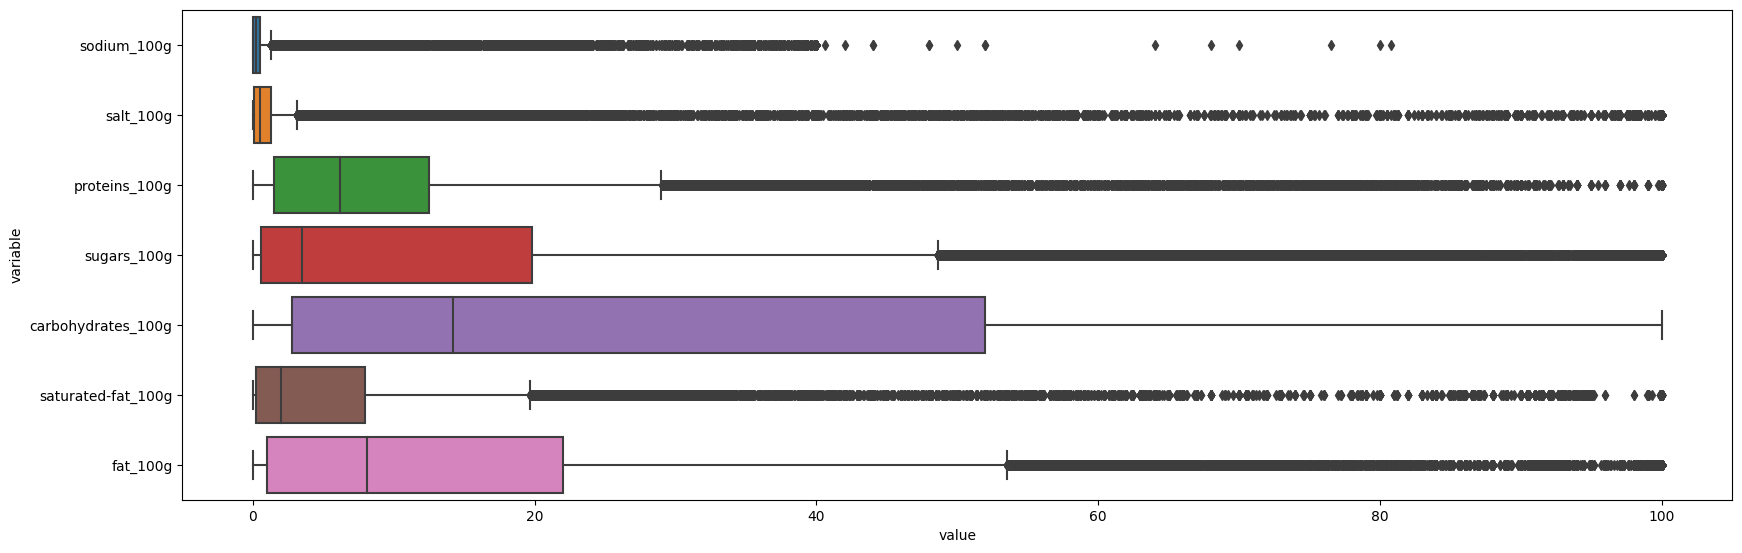

In [76]:
cols = ["fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g"]
show_cols_repartition(df, cols)

### <a id='toc8_10_'></a>[Combinaisons](#toc0_)

#### <a id='toc8_10_1_'></a>[saturated-fat_100g, fat_100g](#toc0_)

Les acides gras saturés fontpartie des matières grasses. Noous devons donc avoir saturated-fat_100g	<= fat_100g

In [77]:
df.loc[df["fat_100g"]<df["saturated-fat_100g"]].shape

(326, 19)

Nous avons 759 produits ne respectant pas cette contrainte

In [78]:
for ind in df.loc[(df["fat_100g"]<df["saturated-fat_100g"]) & ~df["main_category"].isna()].index:
    for col_to_fix in ["fat_100g", "saturated-fat_100g"]:
        ref_value = df.loc[ind, "main_category"]
        cu.fix_var_with_median(df, "main_category", ref_value, ind, col_to_fix, verbose=False)

In [79]:
tot = df.loc[df["fat_100g"]<df["saturated-fat_100g"]].shape[0]
cur_i = 0;
for ind in df.loc[df["fat_100g"]<df["saturated-fat_100g"]].index:
    for col_to_fix in ["fat_100g", "saturated-fat_100g"]:
        ref_value = df.loc[ind, "product_name"]
        cu.fix_var_with_median(df, "product_name", ref_value, ind, col_to_fix, verbose=False)
    cur_i += 1
    if cur_i % 20 == 0:
        print(f"{cur_i}/{tot}")
df.loc[df["fat_100g"]<df["saturated-fat_100g"]].shape

20/76
40/76
60/76


(56, 19)

In [80]:
df.loc[df["fat_100g"]<df["saturated-fat_100g"]]

code                                       product_name  \
6421     0034000000982                             Sours sugar free mints   
16095    0078895740035                Lee kum kee, chinese barbecue sauce   
31700    0204116025913                          sandwich américain jambon   
46669    0212587071766                               Pieces a fondu Boeuf   
75381    0709112457237                                          Slim Rice   
78461    0770333025000                                       Baba Gannouj   
97876    2000000035354                                     Sweet Imperial   
107218        20074692                              Naturis sabor a limão   
111689        20226015                            Magic Triple Schokolade   
130018        22104731                                         Lang'Acide   
204076   3038351185005                    Panzani Pasta Spaghetti Express   
205036   3038682066516      Coffret 8 pcs avocat crevettes comptoir sushi   
254464   3234750013189                            Raisins Blonds Thompson   
255157   3237850005146  Préparation pour brouillage crème de truffes d...   
262338   3250390193364                Suiss'fruits, Fromages Frais Sucrés   
262614   3250390339281                                       Salade mêlée   
265579   3250391526574                                    Persillade 250g   
283989   3257630013697                L'écrasé pomme de terre et brandade   
329610   3284896485265              Crunchy chicken with soy garlic sauce   
347447   3325890100287                       Croques a poêle leader Price   
363058   3350031596032                    Café soluble, cappuccino nature   
370102   3363570508015                                     Appetit chèvre   
387054   3396411234163                                Mini douceur amande   
394211   3418840572323    Mélange calmars et poulpe au basilic et  origan   
396917   3424030000040                            Saucisse fraiche grosse   
415642   3465410004012                                     Fraise surgele   
425085   3495867879062                             Boisson chocolat blanc   
440833   3540869464775                             Nonnettes miel abricot   
462623   3564706617544                Fruits rouges moelleuses 3 céréales   
465433   3564884022178                        Maté saveur chocolat orange   
466419  35670045944704                              thon entier albacoire   
471451   3581084781407                         Sandwich club tomate mozza   
498927   3665069444614                                Feed proteine shoot   
509446   3700294600791                                  Cacahuètes cuites   
517263   3700662751254                                 Mi navette lavande   
520410   3700892415872                                      myrtilles bio   
534415   3760023261341        Palourdes cuites farcies au beurre persillé   
553286   3760096360088                                       Soda soukous   
591804   3760282062895                                   La classic cesar   
597043   3765872156282                                      Bun provencal   
631796   4012200387900                                       Kirschgrütze   
634972   4020607523609                             Tartare de rouge gorge   
644838   4061458040778                                       Würfelzucker   
646064   4071800039107                                        Vital + Fit   
670149   5010693601236                 Quality Smoothie Mango 3 x (270ml)   
677812   5051882198465                                    rich toffee bar   
683369   5060138531475                     Gemüse Chipotle-Chili mit Reis   
684371   5060230930046                        Choc chick raw cocoa powder   
685358   5060337505017                     Monster Ultra Zero Zucker weiß   
752231   7610553512030                                      Alp tea relax   
753619   7611471000913                              Milupa - Safari Kekse   
753628   76114

In [81]:
for ind in df.loc[(df["fat_100g"]<df["saturated-fat_100g"]) & ~df["pnns_groups_2"].isna()].index:
    for col_to_fix in ["fat_100g", "saturated-fat_100g"]:
        ref_value = df.loc[ind, "pnns_groups_2"]
        cu.fix_var_with_median(df, "pnns_groups_2", ref_value, ind, col_to_fix, verbose=False)

In [82]:
df.loc[df["fat_100g"]<df["saturated-fat_100g"]].shape

(54, 19)

In [83]:
df.drop(df.loc[df["fat_100g"]<df["saturated-fat_100g"]].index, inplace=True)
df.reset_index(inplace=True, drop=True)

#### <a id='toc8_10_2_'></a>[carbohydrates_100g, sugars_100g](#toc0_)

Les sucres font partie des glucides. Nous devons donc avoir sugars_100g <= carbohydrates_100g

In [84]:
df.loc[df["sugars_100g"]>df["carbohydrates_100g"]].shape

(924, 19)

In [85]:
for ind in df.loc[(df["sugars_100g"]>df["carbohydrates_100g"]) & ~df["main_category"].isna()].index:
    for col_to_fix in ["sugars_100g", "carbohydrates_100g"]:
        ref_value = df.loc[ind, "main_category"]
        cu.fix_var_with_median(df, "main_category", ref_value, ind, col_to_fix, verbose=False)

In [86]:
for ind in df.loc[(df["sugars_100g"]>df["carbohydrates_100g"]) & ~df["pnns_groups_2"].isna()].index:
    for col_to_fix in ["sugars_100g", "carbohydrates_100g"]:
        ref_value = df.loc[ind, "pnns_groups_2"]
        cu.fix_var_with_median(df, "pnns_groups_2", ref_value, ind, col_to_fix, verbose=False)

In [87]:
tot = df.loc[df["sugars_100g"]>df["carbohydrates_100g"]].shape[0]
cur_i = 0;
for ind in df.loc[df["sugars_100g"]>df["carbohydrates_100g"]].index:
    for col_to_fix in ["sugars_100g", "carbohydrates_100g"]:
        ref_value = df.loc[ind, "product_name"]
        cu.fix_var_with_median(df, "product_name", ref_value, ind, col_to_fix, verbose=False)
    cur_i += 1
    if cur_i % 20 == 0:
        print(f"{cur_i}/{tot}")
df.loc[df["sugars_100g"]>df["carbohydrates_100g"]].shape

20/481
40/481
60/481
80/481
100/481
120/481
140/481
160/481
180/481
200/481
220/481
240/481
260/481
280/481
300/481
320/481
340/481
360/481
380/481
400/481
420/481
440/481
460/481
480/481


(345, 19)

In [88]:
df.drop(df.loc[df["carbohydrates_100g"]<df["sugars_100g"]].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [89]:
df.to_parquet(f"{working_dir}/tmp.parquet")

#### <a id='toc8_10_3_'></a>[fat_100g, carbohydrates_100g, proteins_100g, salt_100g](#toc0_)

Nous savons que les nutriments sont divisés en plusieurs classes:
- matières grasses (fat_100g)
- glucides (carbohydrates_100g)
- protéines (proteins_100g)
- sel (salt_100g)
- autres (vitamines, calcium, etc...)

On doit donc avoir :

fat_100g + carbohydrates_100g + proteins_100g + salt_100g <= 100


In [90]:
df.loc[(df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"])>100]

code                    product_name        brands_tags  \
283          0000010216422                    Pâte à sucre               None   
348          0000030005501       From.fond.ste Creme 23%MG               None   
353          0000034163078                         Big cup               None   
357          0000034440094    Reese's 2 Peanut Butter Cups              reese   
367               00000406                        Francais               None   
...                    ...                             ...                ...   
883264       9900000001827  Huile vierge de noix de France  moulin-de-vouthon   
883575  990530101032111794                  Yaos creations               None   
883611  990530101043226305                 Kinder Cereales             kinder   
883846       9985044447442                       Feel good               None   
883955       9999999999994       Light & Free SKYR A BOIRE               None   

        nutriscore_score nutriscore_grade            pnns_groups_1  \
283                  NaN             None                     None   
348                  NaN             None                     None   
353                  NaN             None                     None   
357                  NaN             None                     None   
367                  NaN             None                     None   
...                  ...              ...                      ...   
883264               6.0                c           Fat and sauces   
883575               NaN             None                     None   
883611               NaN             None                     None   
883846               NaN             None                     None   
883955              25.0                e  Milk and dairy products   

         pnns_groups_2                              food_groups_tags  \
283               None                                          None   
348               None                                          None   
353               None                                          None   
357               None                                          None   
367               None                                          None   
...                ...                                           ...   
883264            Fats                    en:fats-and-sauces,en:fats   
883575            None                                          None   
883611            None                                          None   
883846            None                                          None   
883955  Dairy desserts  en:milk-and-dairy-products,en:dairy-desserts   

        completeness      main_category  energy-kcal_100g  energy_100g  \
283           0.2750               None             393.0       1644.0   
348           0.2625               None             269.0       1125.0   
353           0.2750               None             500.0       2092.0   
357           0.4750               None             500.0       2092.0   
367           0.2500               None              25.0        105.0   
...              ...                ...               ...          ...   
883264        0.5750     en:walnut-oils             900.0       3766.0   
883575        0.2750               None              96.0        402.0   
883611        0.3750               None             500.0       2092.0   
883846        0.2750               None               9.0         38.0   
883955        0.3750  en:dairy-desserts              24.0        100.0   

        fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
283          4.8                 3.3                87.1         84.7   
348         83.0                16.0                 1.6          1.6   
353         31.0                10.0                57.0         50.0   
357         31.0                10.7                57.1         50.0   
367          5.0                 1.0                85.0          5.0   
...          ...

On constate 4201 valeurs aberrantes au niveau de la somme fat_100g + carbohydrates_100g + proteins_100g + salt_100g 

Nous allons appliquer la fonction fix_var_with_aux 4 variables (fat_100g, carbohydrates_100g, proteins_100g, salt_100g) median pour ces produits en recherchant les produits avec le même nom.

In [91]:
for ind in df.loc[((df["proteins_100g"]+df["fat_100g"]+df["carbohydrates_100g"]+df["salt_100g"])>100) & ~df["main_category"].isna()].index:
    for col_to_fix in ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g"]:
        ref_value = df.loc[ind, "main_category"]
        cu.fix_var_with_median(df, "main_category", ref_value, ind, col_to_fix, verbose=False)

In [92]:
tot = df.loc[((df["proteins_100g"]+df["fat_100g"]+df["carbohydrates_100g"]+df["salt_100g"])>100)].shape[0]
cur_i = 0;
for ind in df.loc[((df["proteins_100g"]+df["fat_100g"]+df["carbohydrates_100g"]+df["salt_100g"])>100)].index:
    for col_to_fix in ["proteins_100g", "fat_100g", "carbohydrates_100g", "salt_100g"]:
        ref_value = df.loc[ind, "product_name"]
        cu.fix_var_with_median(df, "product_name", ref_value, ind, col_to_fix, verbose=False)
    cur_i += 1
    if cur_i % 20 == 0:
        print(f"{cur_i}/{tot}")
df.loc[(df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"])>100].shape

20/2680
40/2680
60/2680
80/2680
100/2680
120/2680
140/2680
160/2680
180/2680
200/2680
220/2680
240/2680
260/2680
280/2680
300/2680
320/2680
340/2680
360/2680
380/2680
400/2680
420/2680
440/2680
460/2680
480/2680
500/2680
520/2680
540/2680
560/2680
580/2680
600/2680
620/2680
640/2680
660/2680
680/2680
700/2680
720/2680
740/2680
760/2680
780/2680
800/2680
820/2680
840/2680
860/2680
880/2680
900/2680
920/2680
940/2680
960/2680
980/2680
1000/2680
1020/2680
1040/2680
1060/2680
1080/2680
1100/2680
1120/2680
1140/2680
1160/2680
1180/2680
1200/2680
1220/2680
1240/2680
1260/2680
1280/2680
1300/2680
1320/2680
1340/2680
1360/2680
1380/2680
1400/2680
1420/2680
1440/2680
1460/2680
1480/2680
1500/2680
1520/2680
1540/2680
1560/2680
1580/2680
1600/2680
1620/2680
1640/2680
1660/2680
1680/2680
1700/2680
1720/2680
1740/2680
1760/2680
1780/2680
1800/2680
1820/2680
1840/2680
1860/2680
1880/2680
1900/2680
1920/2680
1940/2680
1960/2680
1980/2680
2000/2680
2020/2680
2040/2680
2060/2680
2080/2680
2100/2680
212

(1820, 19)

Il reste encore 1820 valeurs aberrantes au niveau de la somme fat_100g + carbohydrates_100g + proteins_100g + salt_100g. Nous allons nous en occuper plus tard.

In [93]:
df.to_parquet(f"{working_dir}/tmp.parquet")

### <a id='toc8_11_'></a>[energy-kcal_100g](#toc0_)

Pour l'energie, nous avons 2 colonnes: energy-kcal_100g, energy_100g. nous devrions toujours avoir:

energy-kcal_100g * 4.184 = energy_100g

Vérifions cela: pour cela nous cherchons les observations où energy-kcal_100g et energy_100g sont remplies et ou energy_100g/energy-kcal_100g < 4.1 ou >4.2

In [94]:
df.loc[~df["energy-kcal_100g"].isna() & ~df["energy_100g"].isna() & ((df["energy_100g"]/df["energy-kcal_100g"])<4.1) | ((df["energy_100g"]/df["energy-kcal_100g"])>4.2) ]

code                                    product_name  \
82       000000001071                             Thé Oolong Violette   
124      000000002401                                Habitus Stimulus   
186      000000047381                                   Thé louis xiv   
193     0000000620406                                  Bonbon fourres   
248     0000010068175           Thé noir aromatisé violette et fleurs   
...               ...                                             ...   
883776        9945593  Tisane foir et vésicule detoxifiant au romarin   
883802  9956338593435                              Hibiscus cramberry   
883846  9985044447442                                       Feel good   
883891  9998110000045                                 le made in mali   
883901   999901969406                                       Nespresso   

             brands_tags  nutriscore_score nutriscore_grade pnns_groups_1  \
82                  None               NaN             None          None   
124                 None               NaN             None          None   
186                 None               1.0                b          None   
193                 None               NaN             None          None   
248         alice-delice               2.0                c     Beverages   
...                  ...               ...              ...           ...   
883776  vitaflor,milical               NaN             None          None   
883802              None               NaN             None          None   
883846              None               NaN             None          None   
883891              None               NaN             None          None   
883901              None               1.0                b          None   

                pnns_groups_2                       food_groups_tags  \
82                       None                                   None   
124                      None                                   None   
186                      None                                   None   
193                      None                                   None   
248     Unsweetened beverages  en:beverages,en:unsweetened-beverages   
...                       ...                                    ...   
883776                   None                                   None   
883802                   None                                   None   
883846                   None                                   None   
883891                   None                                   None   
883901                   None                                   None   

        completeness                            main_category  \
82            0.2625                                     None   
124           0.2750                                     None   
186           0.3625                                  en:teas   
193           0.2750                                     None   
248           0.5875                             en:beverages   
...              ...                                      ...   
883776        0.4750                                     None   
883802        0.2625                                     None   
883846        0.2750                                     None   
883891        0.2750                                     None   
883901        0.3625  en:nespresso-compatible-coffee-capsules   

        energy-kcal_100g  energy_100g  fat_100g  saturated-fat_100g  \
82                   1.0          4.0       0.0                 0.0   
124                  1.0          4.0       0.0                 0.0   
186                  1.0          4.0       0.0                 0.0   
193                  1.0          4.0       1.0                 1.0   
248                  4.0         17.0       0.1                 0.1   
...                  ...          ...       ...                 ...   
883776               4.0         17.0       0.0                 0.0   
8

Nous avons plus de 41000 observations avec ce problème.

Une recherche sur Internet nous donne une formule approximative :  

energy-kcal_100g = 9 * fat_100g + 4 * carbohydrates_100g + 4 * proteins_100g

In [95]:
df.loc[~df["energy-kcal_100g"].isna() & ~df["energy_100g"].isna() & ~df["fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() & ~df["proteins_100g"].isna() &
    ((df["energy_100g"]/df["energy-kcal_100g"])<4.1) | ((df["energy_100g"]/df["energy-kcal_100g"])>4.2) , "energy-kcal_100g"] = 9* df["fat_100g"] + 4 * df["carbohydrates_100g"] + 4 * df["proteins_100g"]


Nous supprimons la colonne energy_100g

In [96]:
df.drop(columns="energy_100g", inplace=True)
df.reset_index(inplace=True, drop=True)

In [97]:
#df.to_parquet(f"{working_dir}/tmp.parquet")

D'après notre formule de l'énergie d'un aliment, les produits les plus énergétiques sont ceux composés à 100% de matières grasses.

e = 9 * 100

La formule étant approximative, nous allons définir le seuil maximal énergétique pour 100g de 1000 kcal

In [98]:
df.loc[df["energy-kcal_100g"]>1000].shape

(1165, 18)

Nous allons appliquer à nouveau la formule de l'énergie pour ces cas

In [99]:
df.loc[df["energy-kcal_100g"]>1000, "energy-kcal_100g"] = 9 * df["fat_100g"] + 4 * df["carbohydrates_100g"] + 4 * df["proteins_100g"]

In [100]:
df.loc[df["energy-kcal_100g"]>1000].shape

(0, 18)

### <a id='toc8_12_'></a>[Retour sur fat_100g, carbohydrates_100g, proteins_100g, salt_100g](#toc0_)


In [101]:
df.loc[(df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"])>100].shape

(1820, 18)

In [102]:
df.loc[(df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"])>105].shape

(556, 18)

Sur 1845 valeurs aberrantes de la somme de fat_100g, carbohydrates_100g, proteins_100g, salt_100g, nous en avons 571 qui dépassent les 105g. 

Pour celles comprises entre 100 et 105, nous allons rapporter les valeurs de chacunes des features pour avoir une somme à 100.

In [103]:
df["masse"] = df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"]
df.loc[(df["masse"]>100) & (df["masse"]<=105), "fat_100g"] = np.round(np.floor(100 * df["fat_100g"] / df["masse"]) / 10)
df.loc[(df["masse"]>100) & (df["masse"]<=105), "carbohydrates_100g"] = np.round(np.floor(100 * df["carbohydrates_100g"] / df["masse"]) / 10)
df.loc[(df["masse"]>100) & (df["masse"]<=105), "proteins_100g"] = np.round(np.floor(100 * df["proteins_100g"] / df["masse"]) / 10)
df.loc[(df["masse"]>100) & (df["masse"]<=105), "salt_100g"] = np.round(np.floor(100 * df["salt_100g"] / df["masse"]) / 10)
df.drop(columns=["masse"], inplace=True)

On supprime les autres observations.

In [104]:
df.drop(df.loc[((df["fat_100g"]+df["carbohydrates_100g"]+df["proteins_100g"]+df["salt_100g"])>100.1)].index, inplace=True)

In [105]:
df.to_parquet(f"{working_dir}/after_aberrantes.parquet")

## <a id='toc9_'></a>[Représentation des données](#toc0_)

In [106]:
df = pd.read_parquet(f"{working_dir}/after_aberrantes.parquet")

In [107]:
df.describe(include="all")

code product_name brands_tags  nutriscore_score  \
count              883401       883401      450660     329253.000000   
unique             883401       615838       66504               NaN   
top     00000000000000225         Miel      auchan               NaN   
freq                    1          756        9561               NaN   
mean                  NaN          NaN         NaN          9.566844   
std                   NaN          NaN         NaN          8.653664   
min                   NaN          NaN         NaN        -15.000000   
25%                   NaN          NaN         NaN          2.000000   
50%                   NaN          NaN         NaN         11.000000   
75%                   NaN          NaN         NaN         16.000000   
max                   NaN          NaN         NaN         40.000000   

       nutriscore_grade  pnns_groups_1 pnns_groups_2  \
count            329253         375187        375188   
unique                5             11            40   
top                   d  Sugary snacks        Sweets   
freq             104199          79750         35481   
mean                NaN            NaN           NaN   
std                 NaN            NaN           NaN   
min                 NaN            NaN           NaN   
25%                 NaN            NaN           NaN   
50%                 NaN            NaN           NaN   
75%                 NaN            NaN           NaN   
max                 NaN            NaN           NaN   

                  food_groups_tags   completeness main_category  \
count                       376622  883401.000000        432026   
unique                          46            NaN         20429   
top     en:sugary-snacks,en:sweets            NaN  en:groceries   
freq                         35471            NaN         20873   
mean                           NaN       0.468524           NaN   
std                            NaN       0.234634           NaN   
min                            NaN       0.100000           NaN   
25%                            NaN       0.275000           NaN   
50%                            NaN       0.375000           NaN   
75%                            NaN       0.587500           NaN   
max                            NaN       1.100000           NaN   

        energy-kcal_100g       fat_100g  saturated-fat_100g  \
count      676387.000000  691664.000000       696643.000000   
unique               NaN            NaN                 NaN   
top                  NaN            NaN                 NaN   
freq                 NaN            NaN                 NaN   
mean          275.375204      14.149804            5.372939   
std           189.010078      17.373698            7.886717   
min             0.000000       0.000000            0.000000   
25%           113.000000       1.000000            0.200000   
50%           264.700000       8.000000            2.000000   
75%           400.000000      22.000000            8.000000   
max          1000.000000     100.000000          100.000000   

        carbohydrates_100g    sugars_100g  proteins_100g      salt_100g  \
count        691708.000000  696145.000000  693367.000000  657084.000000   
unique                 NaN            NaN            NaN            NaN   
top                    NaN            NaN            NaN            NaN   
freq                   NaN            NaN            NaN            NaN   
mean             27.136911      13.662027       8.736604       1.213367   
std              27.537496      19.946378       9.790981       3.803659   
min               0.000000       0.000000       0.000000       0.000000   
25%               2.800000       0.600000       1.400000       0.060000   
50%              14.000000       3.500000       6.100000       0.530000   
75%              52.000000      19.800000      12.500000       1.300000   
max             100.000000     100.000000     100.000000     100.000000   

          sodium_100

In [108]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883401 entries, 0 to 883956
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                883401 non-null  object 
 1   product_name        883401 non-null  object 
 2   brands_tags         450660 non-null  object 
 3   nutriscore_score    329253 non-null  float64
 4   nutriscore_grade    329253 non-null  object 
 5   pnns_groups_1       375187 non-null  object 
 6   pnns_groups_2       375188 non-null  object 
 7   food_groups_tags    376622 non-null  object 
 8   completeness        883401 non-null  float64
 9   main_category       432026 non-null  object 
 10  energy-kcal_100g    676387 non-null  float64
 11  fat_100g            691664 non-null  float64
 12  saturated-fat_100g  696643 non-null  float64
 13  carbohydrates_100g  691708 non-null  float64
 14  sugars_100g         696145 non-null  float64
 15  proteins_100g       693367 non-nul

Visualisons la répartition des données. Ici, nous n'attachons pas d'importance aux variables code, product_name, brands_tags, main_category et food_group_tags

In [109]:
cols_to_view = [c for c in df.columns if c not in ["code", "product_name", "brands_tags", "food_group_tags", "main_category"]]

In [110]:
df["sugars_100g"].dtype

dtype('float64')

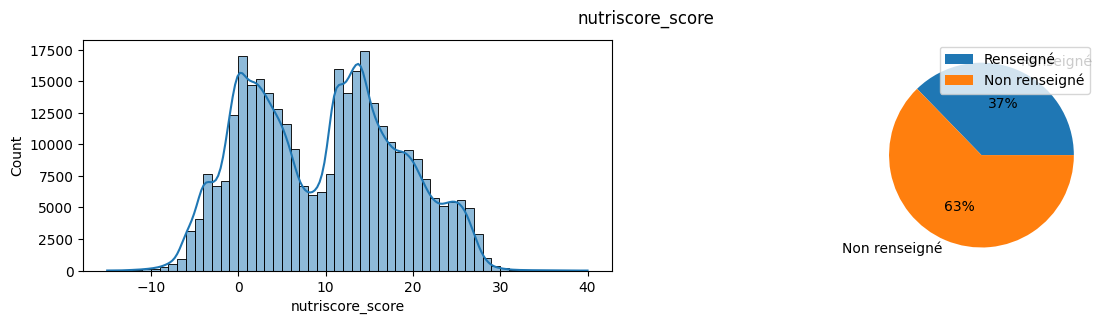

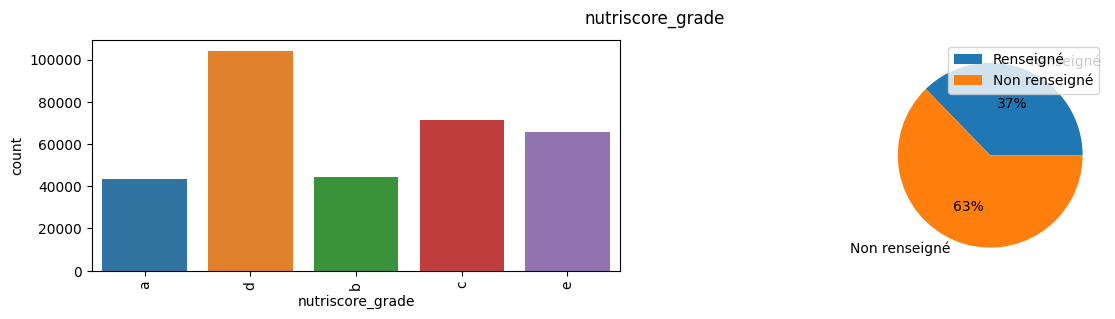

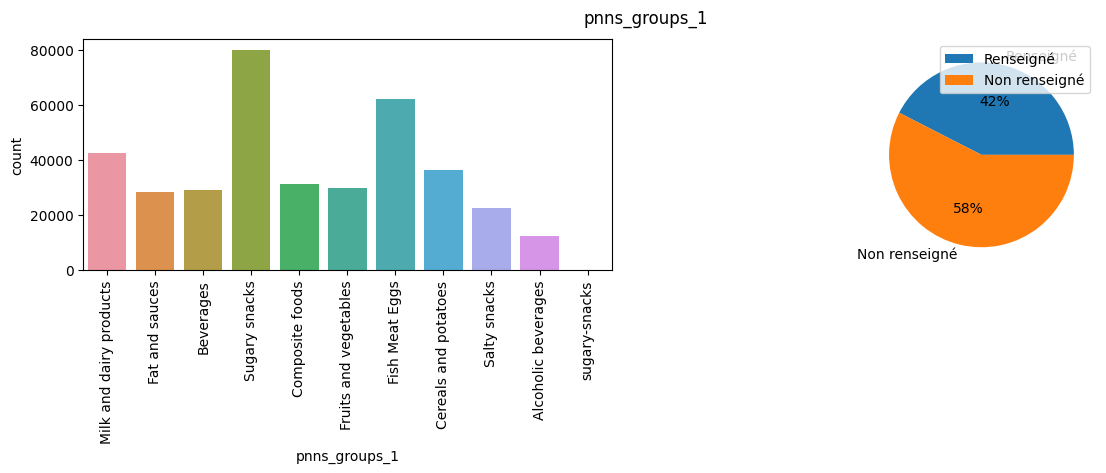

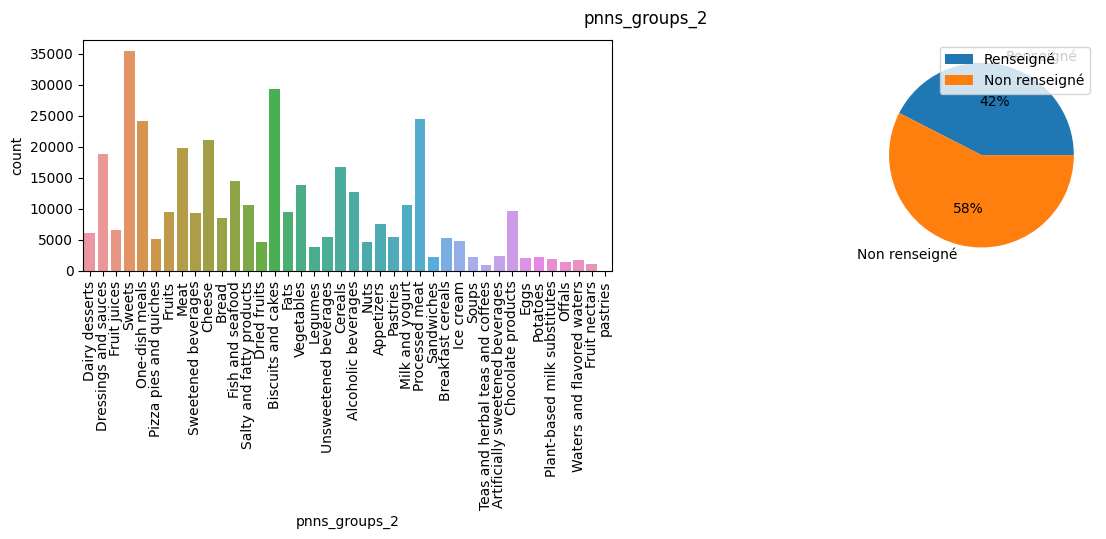

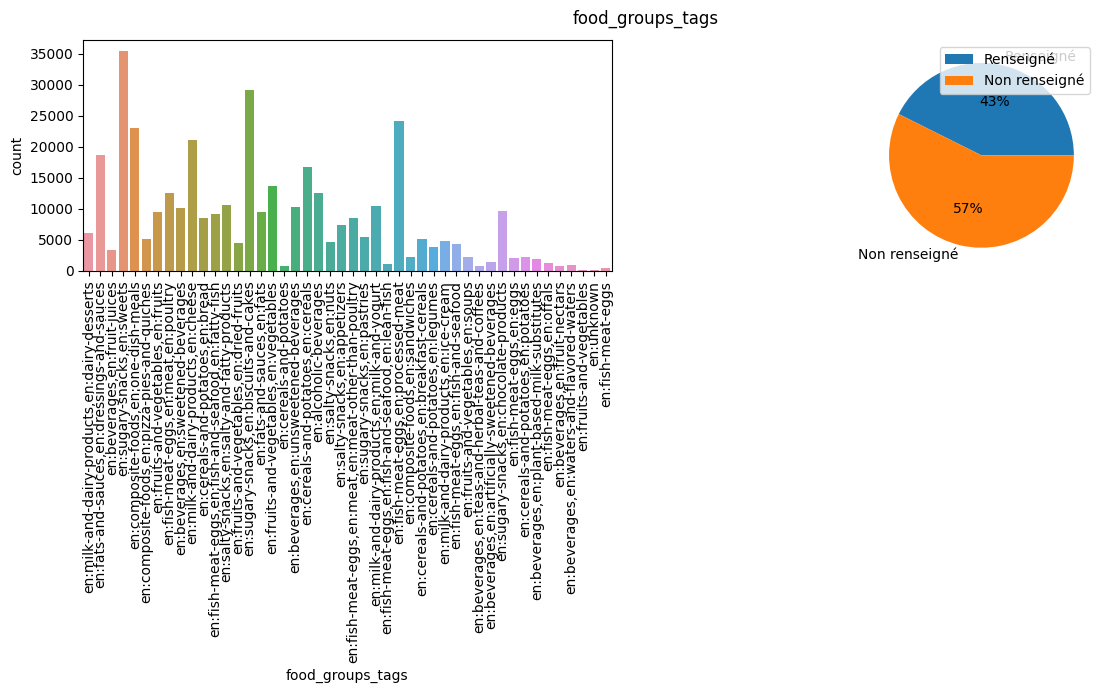

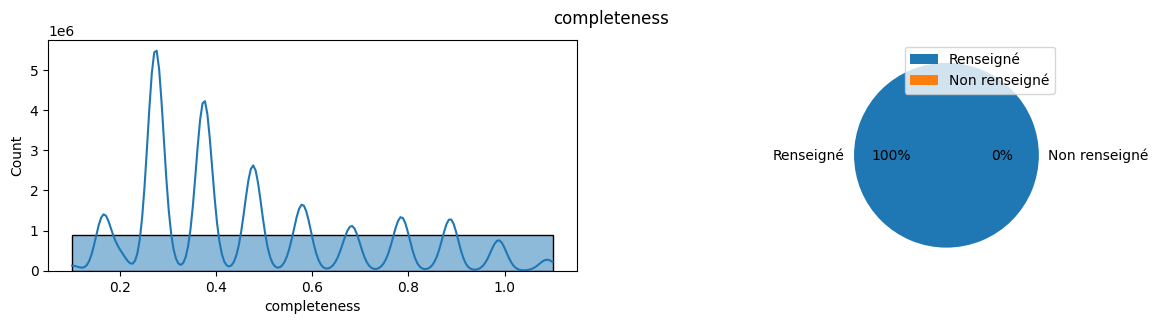

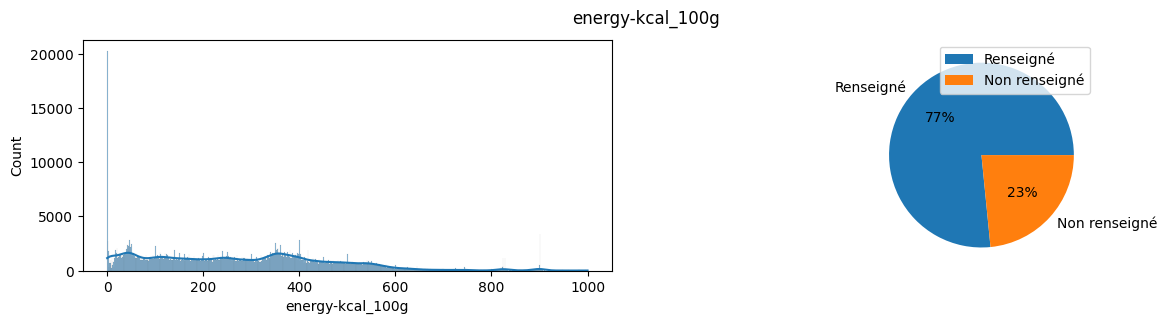

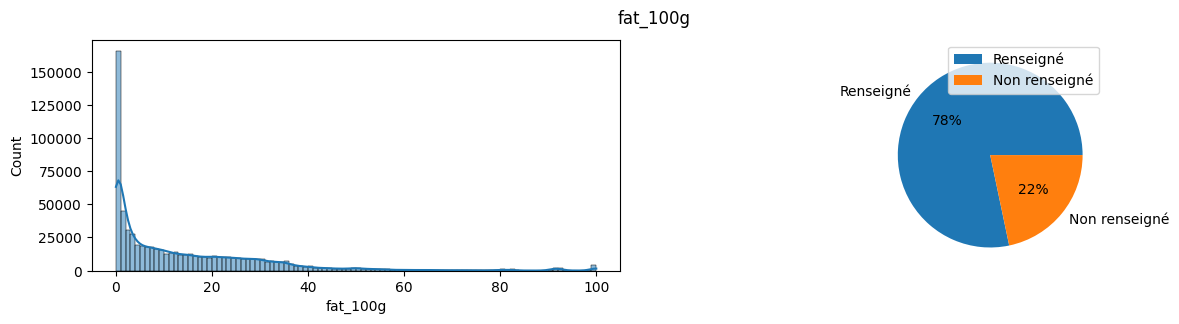

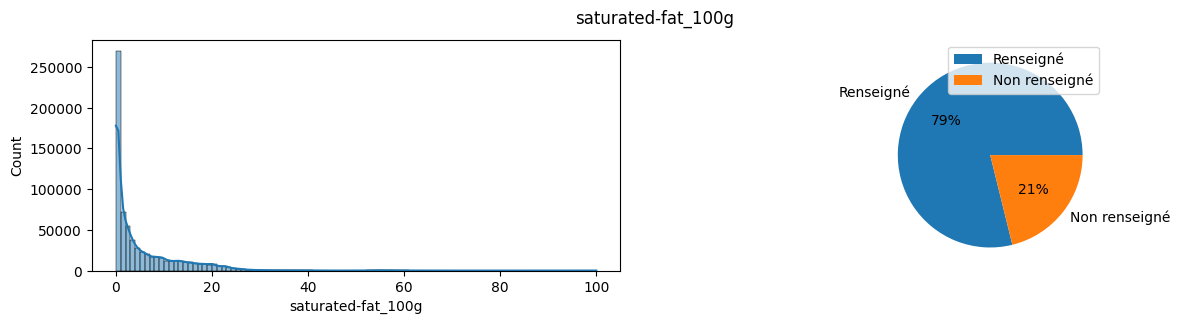

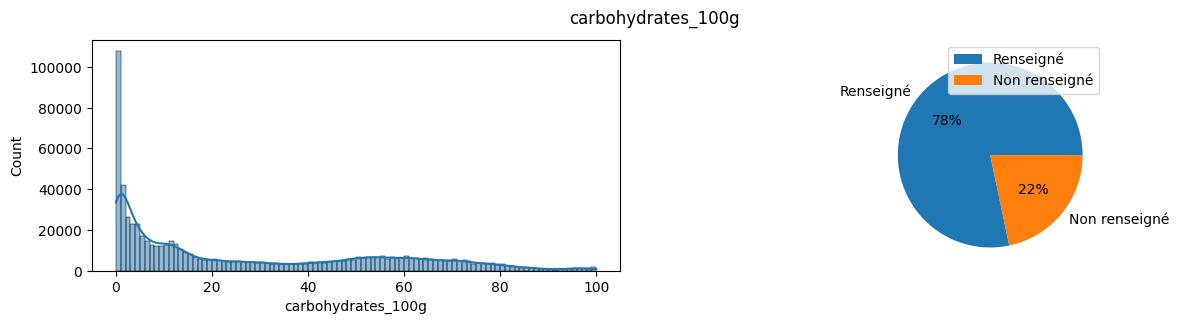

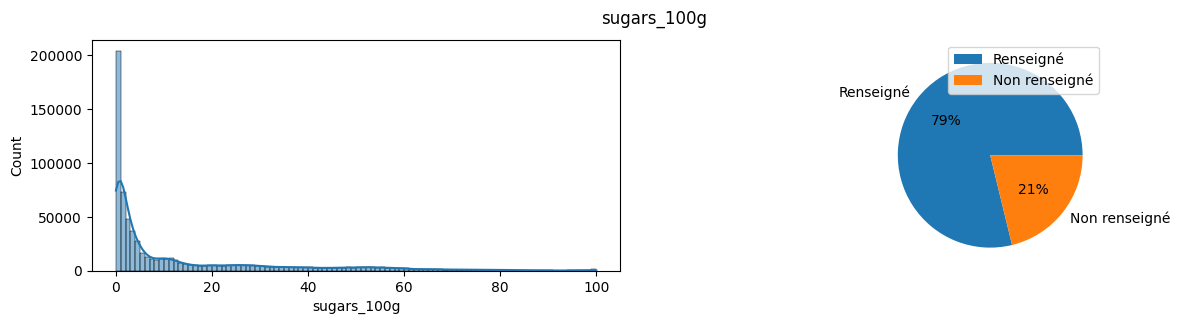

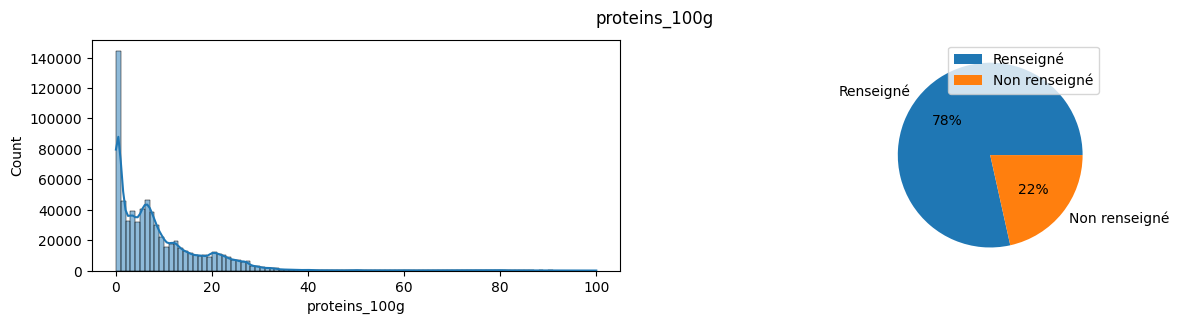

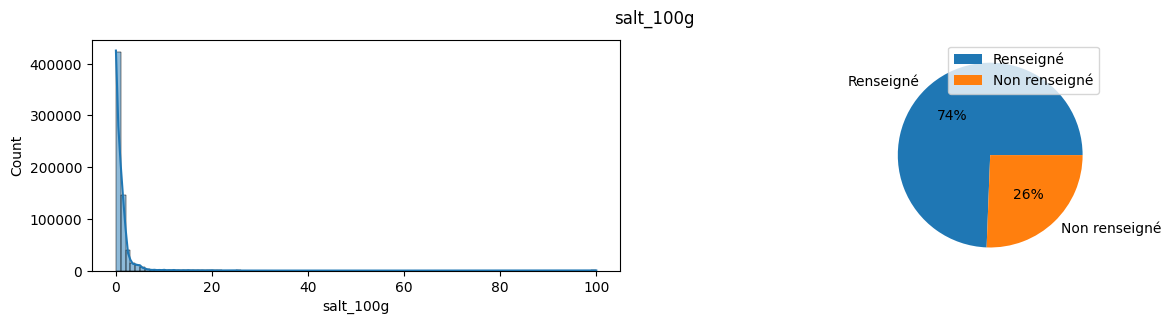

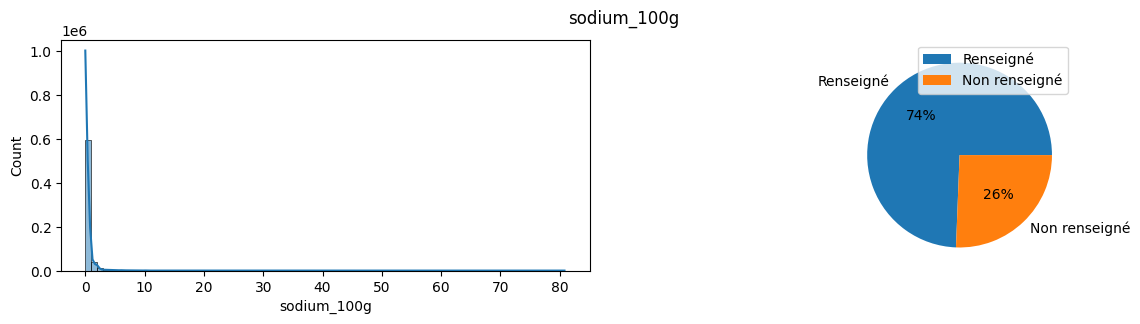

In [111]:
for i in range(0, len(cols_to_view)):
    c = cols_to_view[i]
    f = plt.figure(figsize=(15,3))

    plt.subplot(1,2,1)
    if df[c].dtype=='O':
        g = sns.countplot(x=df[c])
        plt.xticks(rotation=90)
    else:
        sns.histplot(data=df, x=c, kde=True, binwidth=1)

    plt.subplot(1,2,2)

    f.suptitle(c)
    t_rep = {"Renseigné": df.loc[~df[c].isna()].shape[0], "Non renseigné": df.loc[df[c].isna()].shape[0]}
    plt.pie(list(t_rep.values()), labels=list(t_rep.keys()), autopct='%1.0f%%')
    plt.legend(loc=1)
    plt.show()
    

## <a id='toc10_'></a>[Imputation des valeurs manquantes](#toc0_)

In [112]:
df = pd.read_parquet(f"{working_dir}/after_aberrantes.parquet")

### <a id='toc10_1_'></a>[Valeurs quantitatives](#toc0_)

Nous allons ici imputer les valeurs quantitatives nutritionelles manquantes, à savoir: 
- energy-kcal_100g
- fat_100g
- saturated-fat_100g
- carbohydrates_100g
- sugars_100g
- proteins_100g
- salt_100g
- sodium_100g



#### <a id='toc10_1_1_'></a>[Imputation par classes alimentaires](#toc0_)

Nous allons d'abord commencer par utiliser les classes de produits qui nous sont fournies, à savoir:
- main_category
- pnns_groups_1
- pnns_groups_2

pnns_groups_2 et pnns_groups_1 forment une classificaition hierarchique. Nous avons donc intérêt à commencer par pnns_group_2


In [113]:
cols=["energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]

In [114]:
for col in cols:
    pnns_groups_2 = df.loc[~df["pnns_groups_2"].isna() & df[col].isna()]["pnns_groups_2"].unique()
    for pnns2 in pnns_groups_2:
        tmp = df.loc[~df["pnns_groups_2"].isna() & ~df[col].isna() & (df["pnns_groups_2"]==pnns2), col]
        if tmp.shape[0]>0:
            median = np.median(tmp)
            #print(f"col={col}, pnns2={pnns2}, median={median}")
            df.loc[df[col].isna() & ~df["pnns_groups_2"].isna() & (df["pnns_groups_2"]==pnns2), col] = median


col=energy-kcal_100g, pnns2=Dressings and sauces, median=164.0
col=energy-kcal_100g, pnns2=Sweets, median=330.0
col=energy-kcal_100g, pnns2=Meat, median=154.0
col=energy-kcal_100g, pnns2=Sweetened beverages, median=45.0
col=energy-kcal_100g, pnns2=Cheese, median=344.0
col=energy-kcal_100g, pnns2=Fish and seafood, median=180.0
col=energy-kcal_100g, pnns2=Dried fruits, median=312.0
col=energy-kcal_100g, pnns2=One-dish meals, median=139.0
col=energy-kcal_100g, pnns2=Fats, median=828.0
col=energy-kcal_100g, pnns2=Dairy desserts, median=116.0
col=energy-kcal_100g, pnns2=Vegetables, median=37.6
col=energy-kcal_100g, pnns2=Legumes, median=304.0
col=energy-kcal_100g, pnns2=Biscuits and cakes, median=444.0
col=energy-kcal_100g, pnns2=Unsweetened beverages, median=20.0
col=energy-kcal_100g, pnns2=Alcoholic beverages, median=43.0
col=energy-kcal_100g, pnns2=Bread, median=298.0
col=energy-kcal_100g, pnns2=Fruits, median=66.0
col=energy-kcal_100g, pnns2=Milk and yogurt, median=89.0
col=energy-kcal_

Refaisons la même chose avec pnns_groups_1 (au cas où pnns_group_2 ne serait pas renseigné)

In [115]:
cols=["energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]
nb_fixed = 0
for col in cols:
    pnns_groups_1 = df.loc[~df["pnns_groups_1"].isna() & df[col].isna()]["pnns_groups_1"].unique()
    for pnns1 in pnns_groups_1:
        tmp = df.loc[~df["pnns_groups_1"].isna() & ~df[col].isna() & (df["pnns_groups_1"]==pnns1), col]
        if tmp.shape[0]>0:
            median = np.median(tmp)
            #print(f"col={col}, pnns1={pnns2}, median={median}")
            df.loc[df[col].isna() & ~df["pnns_groups_1"].isna() & (df["pnns_groups_1"]==pnns1), col] = median


In [116]:
df.loc[~df["main_category"].isna() & df["energy-kcal_100g"].isna()]["main_category"].unique().shape

(2687,)

In [117]:
cols=["energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]
for col in cols:
    cur_ind = 1
    main_categories = df.loc[~df["main_category"].isna() & df[col].isna()]["main_category"].unique()
    for main_category in main_categories:
        tmp = df.loc[~df["main_category"].isna() & ~df[col].isna() & (df["main_category"]==main_category), col]
        if tmp.shape[0]>0:
            median = np.median(tmp)
            #print(f"col={col}, main_category={main_category}, {cur_ind}/{len(main_categories)} median={median}")
            df.loc[df[col].isna() & ~df["main_category"].isna() & (df["main_category"]==main_category), col] = median
        cur_ind += 1


col=energy-kcal_100g, main_category=en:white-teas, 1/2687 median=4.0
col=energy-kcal_100g, main_category=en:teas, 3/2687 median=1.2000000000000002
col=energy-kcal_100g, main_category=en:test, 4/2687 median=43.0
col=energy-kcal_100g, main_category=en:food-colorings, 5/2687 median=11.5
col=energy-kcal_100g, main_category=en:food-decorations, 7/2687 median=402.0
col=energy-kcal_100g, main_category=en:chestnut-spreads, 8/2687 median=251.0
col=energy-kcal_100g, main_category=fr:beignets-a-la-pomme, 9/2687 median=310.0
col=energy-kcal_100g, main_category=en:instant-beverages, 10/2687 median=349.0
col=energy-kcal_100g, main_category=en:coffee-beans, 11/2687 median=2.0
col=energy-kcal_100g, main_category=en:bcaa, 12/2687 median=5.0
col=energy-kcal_100g, main_category=en:dietary-supplements, 14/2687 median=100.0
col=energy-kcal_100g, main_category=en:protein-powders, 15/2687 median=375.0
col=energy-kcal_100g, main_category=en:cocoa-and-its-products, 16/2687 median=537.5
col=energy-kcal_100g, ma

In [118]:
df.to_parquet(f"{working_dir}/imputed_by_class.parquet")

In [119]:
df = pd.read_parquet(f"{working_dir}/imputed_by_class.parquet")

Visualisons à nouveau la répartition des donnés imputées:

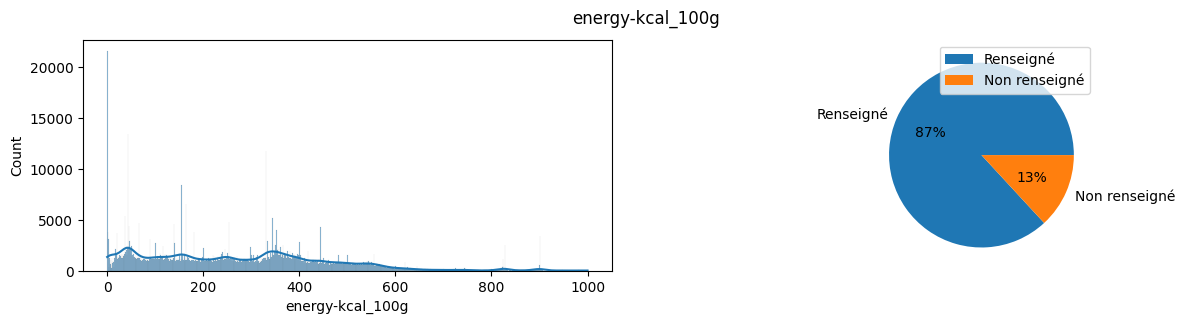

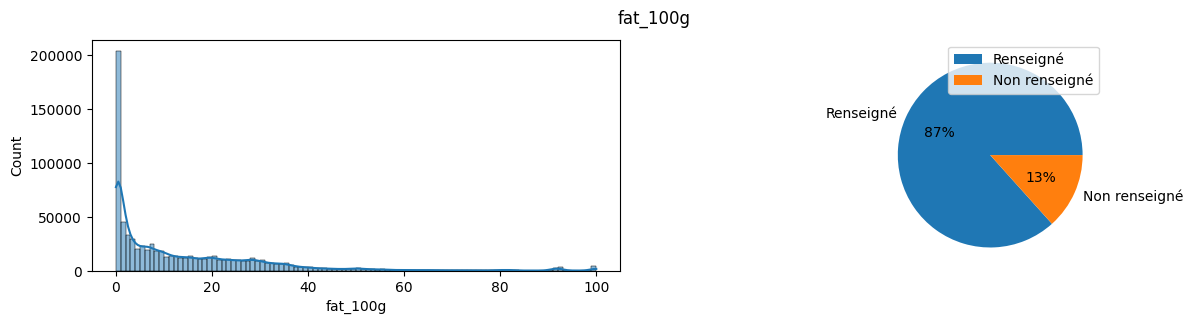

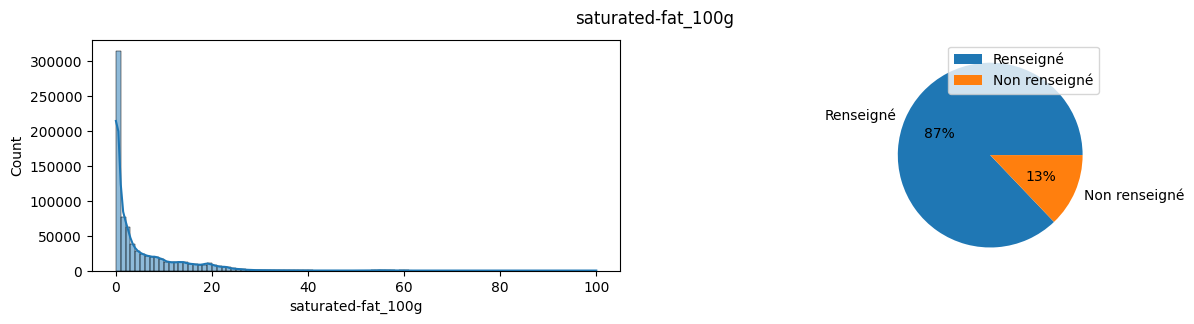

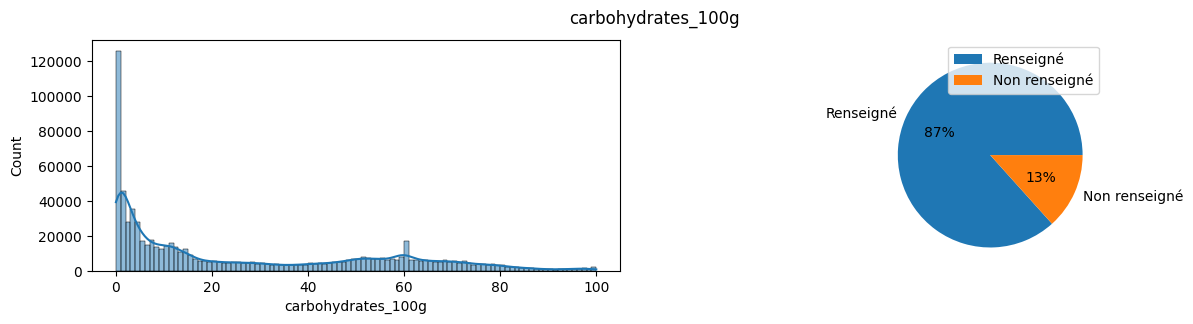

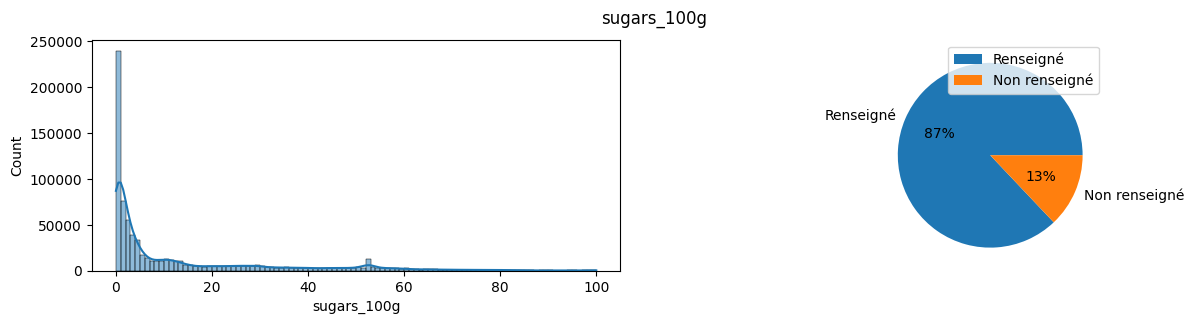

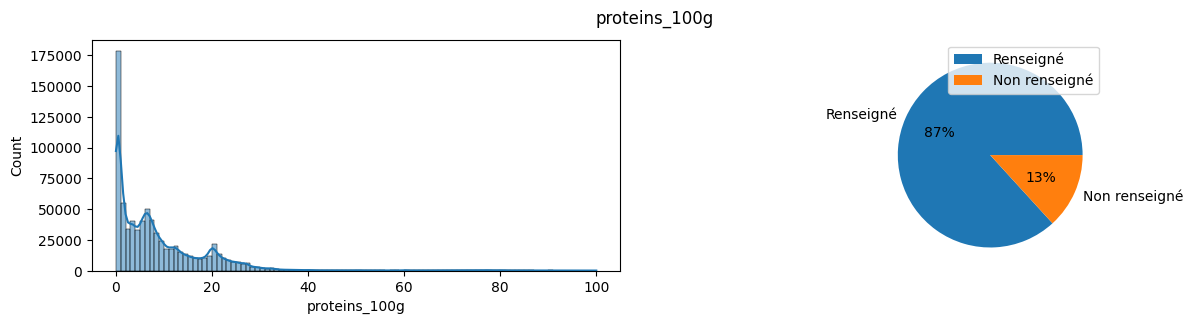

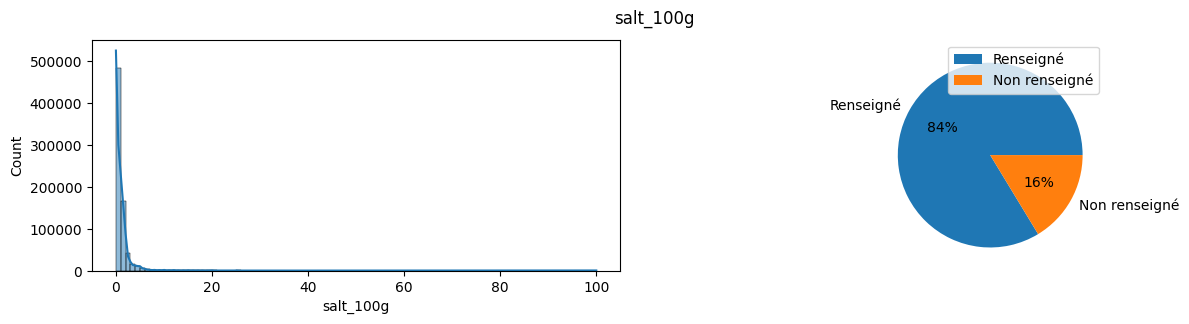

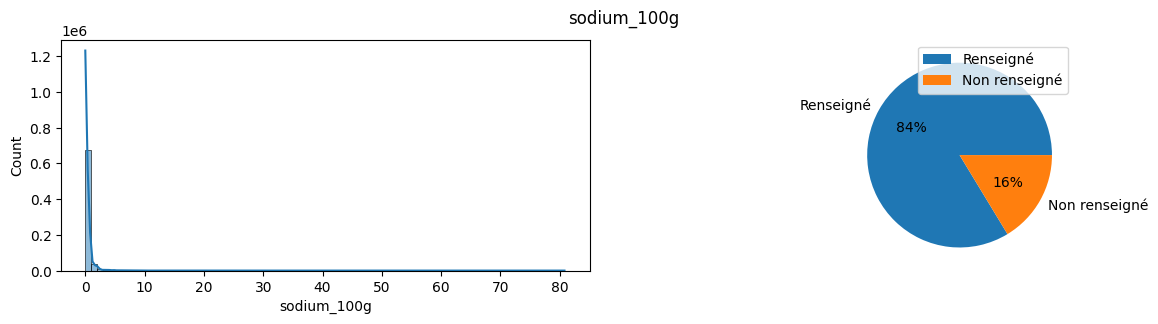

In [120]:
for i in range(0, len(cols)):
    c = cols[i]
    f = plt.figure(figsize=(15,3))

    plt.subplot(1,2,1)
    if df[c].dtype=='O':
        df[c].value_counts().plot(kind='bar')
    else:
        sns.histplot(data=df, x=c, kde=True, binwidth=1)

    plt.subplot(1,2,2)

    f.suptitle(c)
    t_rep = {"Renseigné": df.loc[~df[c].isna()].shape[0], "Non renseigné": df.loc[df[c].isna()].shape[0]}
    plt.pie(list(t_rep.values()), labels=list(t_rep.keys()), autopct='%1.0f%%')
    plt.legend(loc=1)
    plt.show()
    

Nous voyons que nous avons réduit les taux de non-remplissage de 10%

#### <a id='toc10_1_2_'></a>[Imputation par linéarité](#toc0_)

In [176]:
df = pd.read_parquet(f"{working_dir}/imputed_by_class.parquet")
df.reset_index(inplace=True)

In [177]:
fig = px.imshow(
    df.loc[:, ["nutriscore_score", "energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]].corr()
)
fig.show()

On voit 3 relations linéaires fortes:
- salt_100g et sodium_100g
- energy-kcal_100g et fat_100g
- fat_100g et saturated-fat_100g
- sugars_100g et carbohydrates_100g

Nous allons appliquer une imputation par linéarité entre:
- salt_100g et sodium_100g
- energy-kcal_100g, fat_100g et saturated-fat_100g
- sugars_100g et carbohydrates_100g


On commence par créer un nouveau dataframe avec les variables correlées salt_100g et sodium_100g, en s'assurant qu'on ne prend pas les lignes où les 2 variables sont nulles

In [123]:
df_impute = df.loc[~df["salt_100g"].isna() | ~df["sodium_100g"].isna(), ["salt_100g", "sodium_100g"]].copy(deep=True)

On instancie un object IterativeImputer avec l'estimateur LinearRegression (corrélation très haute) et on l'applique sur notre nouveau dataframe, en en créant un nouveau

In [124]:
imputer = IterativeImputer(estimator=LinearRegression(),missing_values=np.nan)
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns, index=df_impute.index)

On peut remplacer les colonnes de départ avec les colonnes imputées

In [125]:
df.loc[df_imputed.index,"salt_100g"] = df_imputed["salt_100g"]
df.loc[df_imputed.index,"sodium_100g"] = df_imputed["sodium_100g"]

Faisons la même chose avec "energy-kcal_100g" et "fat_100g"

In [126]:
df_impute = df.loc[~df["fat_100g"].isna() | ~df["energy-kcal_100g"].isna(), ["energy-kcal_100g", "fat_100g"]]
df_impute = df_impute.copy(deep=True)
imputer = IterativeImputer(estimator=LinearRegression(),missing_values=np.nan)
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns, index=df_impute.index)
df.loc[df_imputed.index,"energy-kcal_100g"] = df_imputed["energy-kcal_100g"]
df.loc[df_imputed.index,"fat_100g"] = df_imputed["fat_100g"]


Faisons la même chose avec "saturated-fat_100g" et "fat_100g"

In [127]:
df_impute = df.loc[~df["saturated-fat_100g"].isna() | ~df["fat_100g"].isna(), ["saturated-fat_100g", "fat_100g"]]
df_impute = df_impute.copy(deep=True)
imputer = IterativeImputer(missing_values=np.nan)
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns, index=df_impute.index)
df.loc[df_imputed.index,"saturated-fat_100g"] = df_imputed["saturated-fat_100g"]
df.loc[df_imputed.index,"fat_100g"] = df_imputed["fat_100g"]


Nous effectuons à nouveau l'opération avec les variables "sugars_100g" et "carbohydrates_100g"

In [128]:
df_impute = df.loc[:, ["sugars_100g", "carbohydrates_100g"]].copy(deep=True)
imputer = IterativeImputer()
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns)
df["sugars_100g"] = df_imputed["sugars_100g"]
df["carbohydrates_100g"] = df_imputed["carbohydrates_100g"]

In [179]:
fig = px.imshow(
    df.loc[:, ["nutriscore_score", "energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]].corr()
)
fig.show()

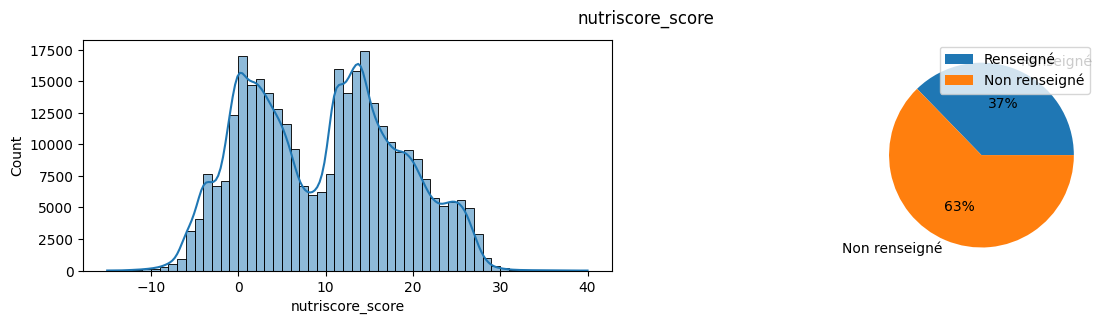

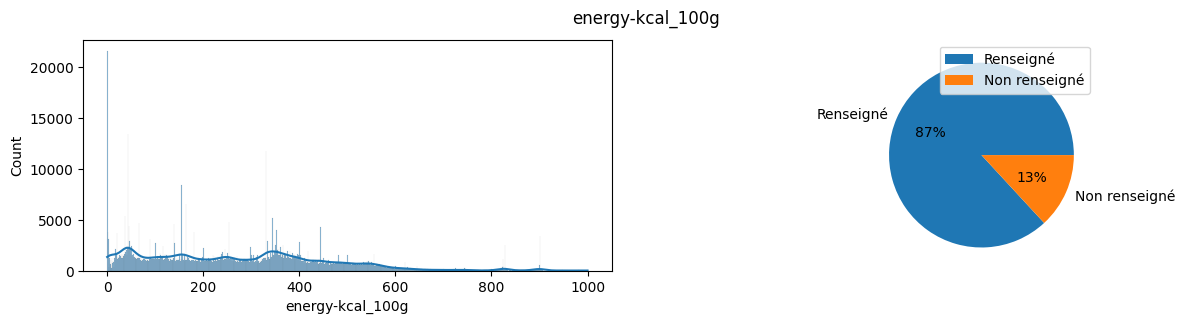

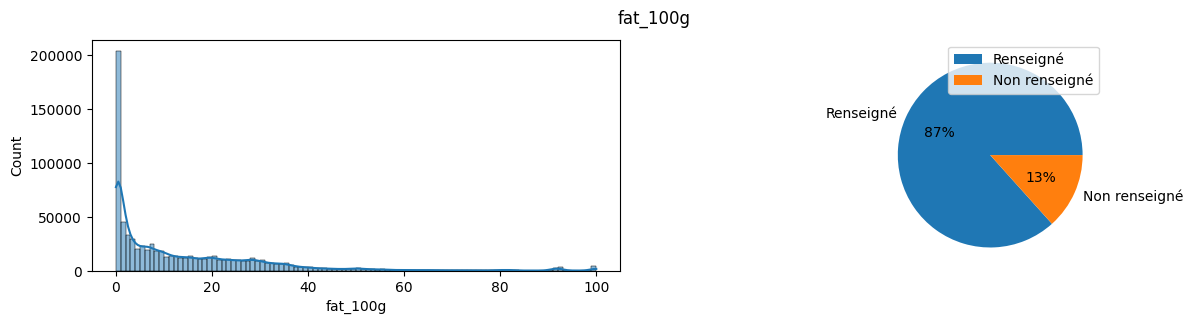

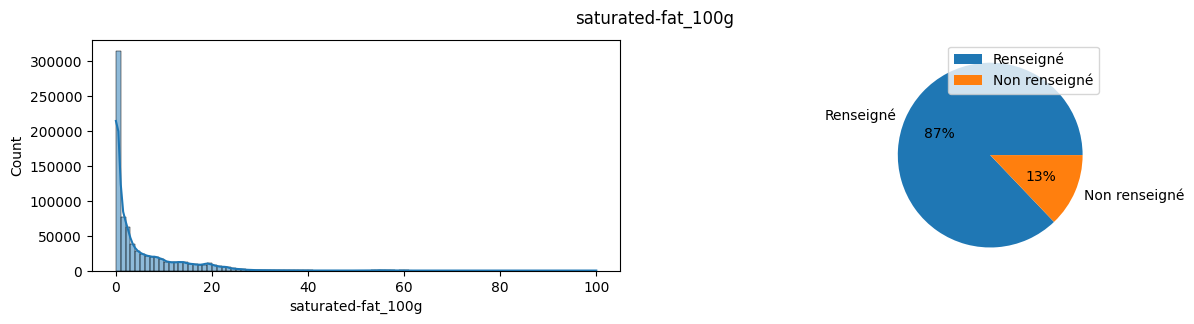

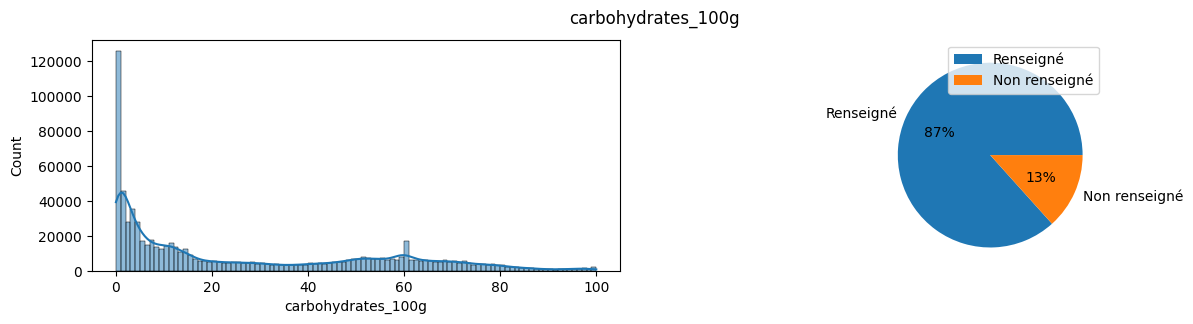

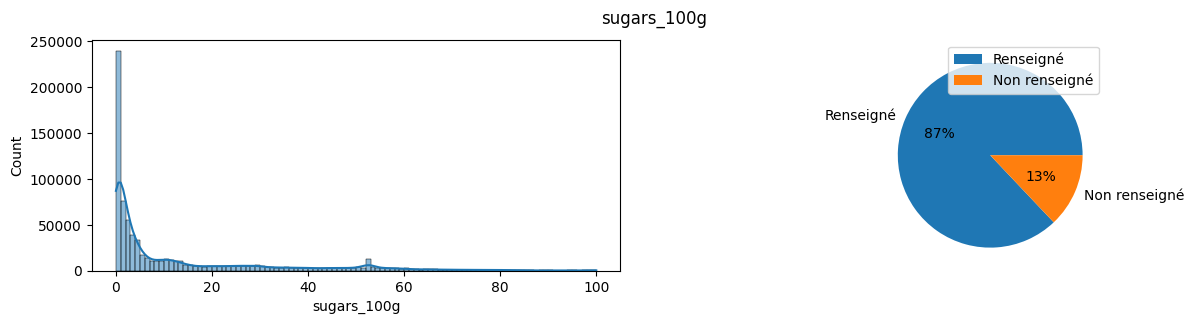

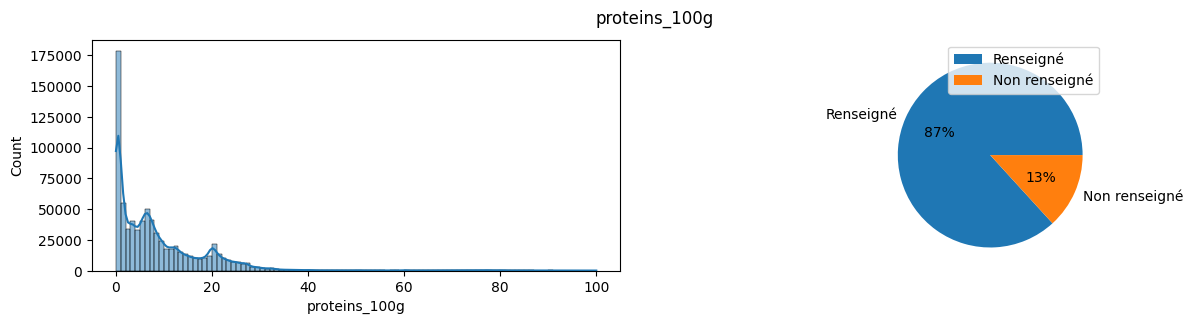

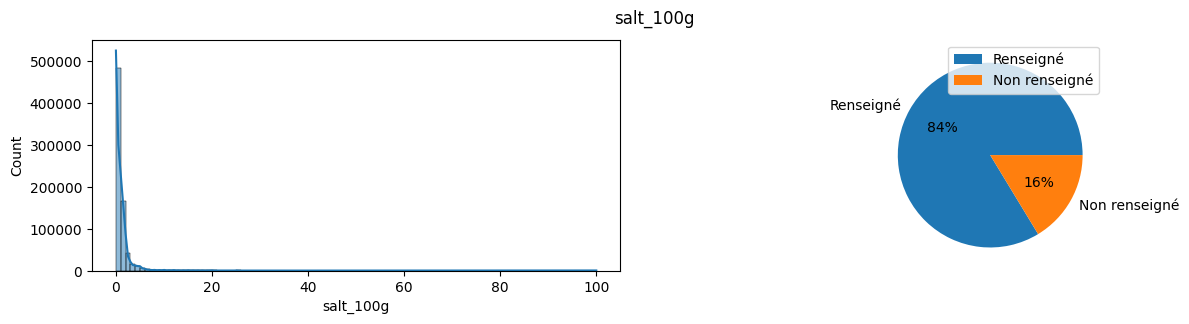

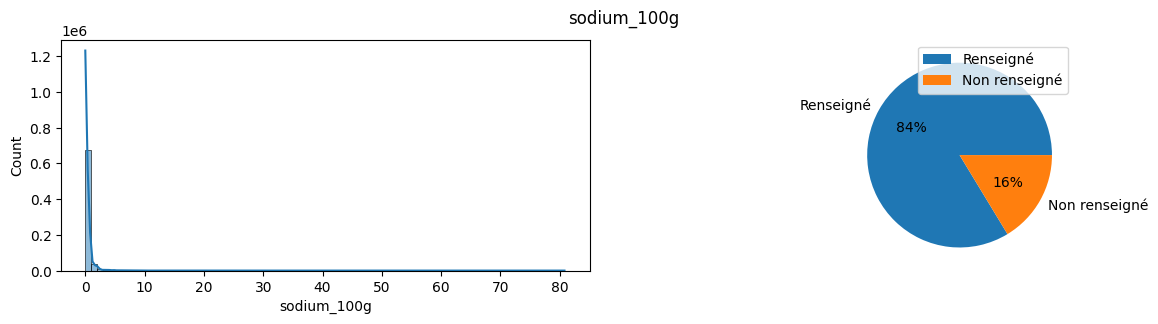

In [180]:
cols=["nutriscore_score", "energy-kcal_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","proteins_100g","salt_100g","sodium_100g"]
for i in range(0, len(cols)):
    c = cols[i]
    f = plt.figure(figsize=(15,3))

    plt.subplot(1,2,1)
    if df[c].dtype=='O':
        df[c].value_counts().plot(kind='bar')
    else:
        sns.histplot(data=df, x=c, kde=True, binwidth=1)

    plt.subplot(1,2,2)

    f.suptitle(c)
    t_rep = {"Renseigné": df.loc[~df[c].isna()].shape[0], "Non renseigné": df.loc[df[c].isna()].shape[0]}
    plt.pie(list(t_rep.values()), labels=list(t_rep.keys()), autopct='%1.0f%%')
    plt.legend(loc=1)
    plt.show()
    

In [181]:
df.to_parquet(f"{working_dir}/imputed_iterative.parquet")

## <a id='toc11_'></a>[Correction des erreurs incrustées par imputation](#toc0_)

In [182]:
df = pd.read_parquet(f"{working_dir}/imputed_iterative.parquet")

Nous allons utiliser les contraintes de masses pour nettoyer des erreurs dûes aux imputations.

In [183]:
def fix_errors_values(df, index_to_fix, col_to_fix=""):
    if col_to_fix.strip() == "":
        raise Exception("Aucune colonne fournie")
    if col_to_fix not in df.columns:
        raise (f"La colonne {col_to_fix} n'existe pas dans le dataframe fourni.")

    for _ref_col in [
        "product_name",
        "main_category",
        "food_groups_tags",
        "pnns_groups_2"
    ]:
        ref_val = df.loc[index_to_fix, _ref_col]
        if pd.isna(ref_val):
            continue
        ref_indexes = df.loc[df[_ref_col]==ref_val].index
        cu.fix_var_with_median_ref_indexes(
            df, ref_indexes, index_to_fix, col_to_fix, verbose=False
        )


In [134]:
df.loc[(df["sugars_100g"] > df["carbohydrates_100g"])].shape

(2222, 19)

Les différentes imputations ont incrusté 2222 valeurs aberrantes pour le couple sugars_100g/carbohydrates_100g

Nous allons tenter de les corriger en utilisant la fonction fix_errors_values

In [135]:
indexes_to_fix = df.loc[(df["sugars_100g"] > df["carbohydrates_100g"])].index

cur_nb = 0
for index_to_fix in indexes_to_fix:
    fix_errors_values(df, index_to_fix, "sugars_100g")
    fix_errors_values(df, index_to_fix, "carbohydrates_100g")
    cur_nb += 1
    if cur_nb % 10:
        print(f"{cur_nb}/{len(indexes_to_fix)}")

1/2222
2/2222
3/2222
4/2222
5/2222
6/2222
7/2222
8/2222
9/2222
11/2222
12/2222
13/2222
14/2222
15/2222
16/2222
17/2222
18/2222
19/2222
21/2222
22/2222
23/2222
24/2222
25/2222
26/2222
27/2222
28/2222
29/2222
31/2222
32/2222
33/2222
34/2222
35/2222
36/2222
37/2222
38/2222
39/2222
41/2222
42/2222
43/2222
44/2222
45/2222
46/2222
47/2222
48/2222
49/2222
51/2222
52/2222
53/2222
54/2222
55/2222
56/2222
57/2222
58/2222
59/2222
61/2222
62/2222
63/2222
64/2222
65/2222
66/2222
67/2222
68/2222
69/2222
71/2222
72/2222
73/2222
74/2222
75/2222
76/2222
77/2222
78/2222
79/2222
81/2222
82/2222
83/2222
84/2222
85/2222
86/2222
87/2222
88/2222
89/2222
91/2222
92/2222
93/2222
94/2222
95/2222
96/2222
97/2222
98/2222
99/2222
101/2222
102/2222
103/2222
104/2222
105/2222
106/2222
107/2222
108/2222
109/2222
111/2222
112/2222
113/2222
114/2222
115/2222
116/2222
117/2222
118/2222
119/2222
121/2222
122/2222
123/2222
124/2222
125/2222
126/2222
127/2222
128/2222
129/2222
131/2222
132/2222
133/2222
134/2222
135/2222
1

In [136]:
df.loc[(df["sugars_100g"] > df["carbohydrates_100g"])].shape

(954, 19)

In [137]:
df.loc[(df["saturated-fat_100g"] > df["fat_100g"])].shape

(5304, 19)

In [138]:
indexes_to_fix = df.loc[(df["saturated-fat_100g"] > df["fat_100g"])].index

cur_nb = 0
for index_to_fix in indexes_to_fix:
    fix_errors_values(df, index_to_fix, "saturated-fat_100g")
    fix_errors_values(df, index_to_fix, "fat_100g")
    cur_nb += 1
    if cur_nb % 10:
        print(f"{cur_nb}/{len(indexes_to_fix)}")

1/5304
2/5304
3/5304
4/5304
5/5304
6/5304
7/5304
8/5304
9/5304
11/5304
12/5304
13/5304
14/5304
15/5304
16/5304
17/5304
18/5304
19/5304
21/5304
22/5304
23/5304
24/5304
25/5304
26/5304
27/5304
28/5304
29/5304
31/5304
32/5304
33/5304
34/5304
35/5304
36/5304
37/5304
38/5304
39/5304
41/5304
42/5304
43/5304
44/5304
45/5304
46/5304
47/5304
48/5304
49/5304
51/5304
52/5304
53/5304
54/5304
55/5304
56/5304
57/5304
58/5304
59/5304
61/5304
62/5304
63/5304
64/5304
65/5304
66/5304
67/5304
68/5304
69/5304
71/5304
72/5304
73/5304
74/5304
75/5304
76/5304
77/5304
78/5304
79/5304
81/5304
82/5304
83/5304
84/5304
85/5304
86/5304
87/5304
88/5304
89/5304
91/5304
92/5304
93/5304
94/5304
95/5304
96/5304
97/5304
98/5304
99/5304
101/5304
102/5304
103/5304
104/5304
105/5304
106/5304
107/5304
108/5304
109/5304
111/5304
112/5304
113/5304
114/5304
115/5304
116/5304
117/5304
118/5304
119/5304
121/5304
122/5304
123/5304
124/5304
125/5304
126/5304
127/5304
128/5304
129/5304
131/5304
132/5304
133/5304
134/5304
135/5304
1

In [139]:
df.loc[(df["saturated-fat_100g"] > df["fat_100g"])].shape

(3692, 19)

In [140]:
df.loc[(df["fat_100g"] + df["carbohydrates_100g"] + df["proteins_100g"] + df["salt_100g"]) > 100].shape

(342, 19)

In [141]:
indexes_to_fix = df.loc[(df["fat_100g"] + df["carbohydrates_100g"] + df["proteins_100g"] + df["salt_100g"]) > 100].index

cur_nb = 0
for index_to_fix in indexes_to_fix:
    fix_errors_values(df, index_to_fix, "sugars_100g")
    fix_errors_values(df, index_to_fix, "carbohydrates_100g")
    fix_errors_values(df, index_to_fix, "fat_100g")
    fix_errors_values(df, index_to_fix, "salt_100g")
    cur_nb += 1
    if cur_nb % 10:
        print(f"{cur_nb}/{len(indexes_to_fix)}")

1/342
2/342
3/342
4/342
5/342
6/342
7/342
8/342
9/342
11/342
12/342
13/342
14/342
15/342
16/342
17/342
18/342
19/342
21/342
22/342
23/342
24/342
25/342
26/342
27/342
28/342
29/342
31/342
32/342
33/342
34/342
35/342
36/342
37/342
38/342
39/342
41/342
42/342
43/342
44/342
45/342
46/342
47/342
48/342
49/342
51/342
52/342
53/342
54/342
55/342
56/342
57/342
58/342
59/342
61/342
62/342
63/342
64/342
65/342
66/342
67/342
68/342
69/342
71/342
72/342
73/342
74/342
75/342
76/342
77/342
78/342
79/342
81/342
82/342
83/342
84/342
85/342
86/342
87/342
88/342
89/342
91/342
92/342
93/342
94/342
95/342
96/342
97/342
98/342
99/342
101/342
102/342
103/342
104/342
105/342
106/342
107/342
108/342
109/342
111/342
112/342
113/342
114/342
115/342
116/342
117/342
118/342
119/342
121/342
122/342
123/342
124/342
125/342
126/342
127/342
128/342
129/342
131/342
132/342
133/342
134/342
135/342
136/342
137/342
138/342
139/342
141/342
142/342
143/342
144/342
145/342
146/342
147/342
148/342
149/342
151/342
152/342
153

In [142]:
df.loc[(df["fat_100g"] + df["carbohydrates_100g"] + df["proteins_100g"] + df["salt_100g"]) > 100].shape

(95, 19)

Nous allons supprimer toutes les observations qui ne respectent toujous pas les contraintes de masses

In [143]:
df = df.loc[(df["sugars_100g"] <= df["carbohydrates_100g"])]
df = df.loc[(df["saturated-fat_100g"] <= df["fat_100g"])]
df = df.loc[(df["fat_100g"] + df["carbohydrates_100g"] + df["proteins_100g"] + df["salt_100g"]) <= 100]
df.drop(columns="index", inplace=True)
df.reset_index(inplace=True, drop=True)


In [144]:
df.to_parquet(f"{working_dir}/imputed_errors_fixed3.parquet")

## <a id='toc12_'></a>[Imputation par voisinage](#toc0_)


In [145]:
df = pd.read_parquet(f"{working_dir}/imputed_errors_fixed3.parquet")
df.reset_index(inplace=True, drop=True)

In [146]:
df.columns

Index(['code', 'product_name', 'brands_tags', 'nutriscore_score',
       'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2',
       'food_groups_tags', 'completeness', 'main_category', 'energy-kcal_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g'],
      dtype='object')

Les valeurs non remplies restantes doivent encore être remplies autant que faire se peut. 
Nous avons déjà imputé les valeurs manquantes de salt_100g, sodium_100g, energy-kcal_100g, fat_100g, saturated-fat_100g, sugars_100g, proteins_100g et carbohydrates_100g

Pour rappel, nous avons les variables suivantes:
'code', 'product_name', 'brands_tags', 'nutriscore_score',
'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2',
'food_groups_tags', 'completeness', 'main_category', 'energy-kcal_100g',
'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
'proteins_100g', 'salt_100g', 'sodium_100g'

Nous allons supprimer la colonne 'completeness' qui n'a aucune valeur ni au niveau identification, ni au niveau nutritif.

In [147]:
df.drop(columns=["completeness"], inplace=True)

Regardons si nous pouvons imputer des variables catégorielles en fonction des variables quantitatives.

### <a id='toc12_1_'></a>[nutriscore_grade](#toc0_)

In [148]:
df.loc[
    ~df["nutriscore_grade"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(329230, 17)

In [149]:
df.loc[
    df["nutriscore_grade"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(401775, 17)

Nous avons donc une population nutriscore_grade/variables quantitatives de 329253 observations, et  403393 observations avec le nutriscore_grade manquant mais avec les données quantitatives fournies.

Nous allons imputer nutriscore_grade à partir d'un knn 

Nous travaillerons avec plusieurs tailles de dataframe pour évaluer les knn

In [150]:
cu.display_knn_errors(
    df, 
    n_neighbors=[1,2,3,4,5], 
    sizes_to_test=[5000, 10000, 20000, 30000, 50000, 100000, 300000], 
    col_to_predict="nutriscore_grade", 
    data_cols=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
)

Nous allons donc utiliser n=1 comme hyperparamètre. Avec cette valeur, nous avons un taux d'erreur de 15%.

On voit aussi que plus la taille de l'échantillon augmente, plus l'erreur diminue

In [151]:
knn = neighbors.KNeighborsClassifier(1)
df_knn = df.loc[
    ~df["nutriscore_grade"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
]
data = df_knn.loc[:, ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']]
target = df_knn.loc[:, "nutriscore_grade"]
knn.fit(data, target)

predicted = knn.predict(
    df.loc[
        df["nutriscore_grade"].isna() &
        ~df["fat_100g"].isna() &
        ~df["energy-kcal_100g"].isna() &
        ~df["saturated-fat_100g"].isna() &
        ~df["carbohydrates_100g"].isna() &
        ~df["sugars_100g"].isna() &
        ~df["proteins_100g"].isna() &
        ~df["salt_100g"].isna() &
        ~df["sodium_100g"].isna(),
        ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
    ]
)

df.loc[
    df["nutriscore_grade"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna(),
    ['nutriscore_grade']
] = predicted

### <a id='toc12_2_'></a>[pnns_groups_2](#toc0_)

In [152]:
df.loc[
    ~df["pnns_groups_2"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(375135, 17)

In [153]:
df.loc[
    df["pnns_groups_2"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(355870, 17)

Nous avons donc une population pnns_groups_2/variables quantitatives de 375139 observations, et  357507 observations avec le pnns_groups_2 manquant mais avec les données quantitatives fournies.

Nous allons imputer pnns_groups_2 à partir d'un knn 

In [154]:
cu.display_knn_errors(
    df, 
    n_neighbors=[1,2,3,4,5], 
    sizes_to_test=[5000, 10000, 20000, 30000, 50000, 100000, 300000], 
    col_to_predict="pnns_groups_2", 
    data_cols=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
)

In [155]:
knn = neighbors.KNeighborsClassifier(1)
df_knn = df.loc[
    ~df["pnns_groups_2"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
]
data = df_knn.loc[:, ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']]
target = df_knn.loc[:, "pnns_groups_2"]
knn.fit(data, target)

predicted = knn.predict(
    df.loc[
        df["pnns_groups_2"].isna() &
        ~df["fat_100g"].isna() &
        ~df["energy-kcal_100g"].isna() &
        ~df["saturated-fat_100g"].isna() &
        ~df["carbohydrates_100g"].isna() &
        ~df["sugars_100g"].isna() &
        ~df["proteins_100g"].isna() &
        ~df["salt_100g"].isna() &
        ~df["sodium_100g"].isna(),
        ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
    ]
)

df.loc[
    df["pnns_groups_2"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna(),
    ['pnns_groups_2']
] = predicted

### <a id='toc12_3_'></a>[main_category](#toc0_)

In [156]:
df.loc[
    ~df["main_category"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(429944, 17)

In [157]:
df.loc[
    df["main_category"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(301061, 17)

In [158]:
cu.display_knn_errors(
    df, 
    n_neighbors=[1,2,3,4,5], 
    sizes_to_test=[5000, 10000, 20000, 30000, 50000, 100000, 300000], 
    col_to_predict="main_category", 
    data_cols=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
)

Ici, on voit que les résultats du KNN sur main_category ne sont pas probants.

In [159]:
df["main_category"].unique().shape

(18923,)

Ceci s'explique par le très grand nombre de classes main_category présentes au départ.

Comme nous avons déjà imputé pnns_groups_2, on peut considérer que nous n'avons pas besoin de main_category.

In [160]:
df.drop(columns=["main_category"], inplace=True)

In [161]:
df.loc[
    ~df["food_groups_tags"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(376556, 16)

In [162]:
df.loc[
    df["food_groups_tags"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
].shape

(354449, 16)

In [163]:
cu.display_knn_errors(
    df, 
    n_neighbors=[1,2,3,4,5], 
    sizes_to_test=[5000, 10000, 20000, 30000, 50000, 100000, 300000], 
    col_to_predict="food_groups_tags", 
    data_cols=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
)

In [164]:
knn = neighbors.KNeighborsClassifier(1)
df_knn = df.loc[
    ~df["food_groups_tags"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna()
]
data = df_knn.loc[:, ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']]
target = df_knn.loc[:, "food_groups_tags"]
knn.fit(data, target)

predicted = knn.predict(
    df.loc[
        df["food_groups_tags"].isna() &
        ~df["fat_100g"].isna() &
        ~df["energy-kcal_100g"].isna() &
        ~df["saturated-fat_100g"].isna() &
        ~df["carbohydrates_100g"].isna() &
        ~df["sugars_100g"].isna() &
        ~df["proteins_100g"].isna() &
        ~df["salt_100g"].isna() &
        ~df["sodium_100g"].isna(),
        ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
    ]
)

df.loc[
    df["food_groups_tags"].isna() &
    ~df["fat_100g"].isna() &
    ~df["energy-kcal_100g"].isna() &
    ~df["saturated-fat_100g"].isna() &
    ~df["carbohydrates_100g"].isna() &
    ~df["sugars_100g"].isna() &
    ~df["proteins_100g"].isna() &
    ~df["salt_100g"].isna() &
    ~df["sodium_100g"].isna(),
    ['food_groups_tags']
] = predicted

## <a id='toc13_'></a>[Imputation par déduction: pnss_groups_1](#toc0_)

Ici nous allons simplement retrouver pnns_groups_1 à partir de pnns_groups_2

In [165]:
tmp_df = df.groupby(["pnns_groups_1", "pnns_groups_2"]).size().reset_index().rename(columns={0:'count'})

In [166]:
tmp_df.loc[tmp_df["pnns_groups_1"].isna()]

Empty DataFrame
Columns: [pnns_groups_1, pnns_groups_2, count]
Index: []

In [167]:
fig = px.sunburst(
    data_frame=tmp_df,
    path=["pnns_groups_1", "pnns_groups_2"],
    width=800,
    height=800,
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.show()

In [168]:
pnns_groups = {}
for pnns1 in df["pnns_groups_1"].unique():
    if pd.isna(pnns1):
        continue
    if not pnns1 in pnns_groups:
        pnns_groups[pnns1] = []
    for pnns2 in df.loc[df["pnns_groups_1"]==pnns1]["pnns_groups_2"].unique():
        pnns_groups[pnns1].append(pnns2)
print(pnns_groups)


{'Milk and dairy products': ['Dairy desserts', 'Cheese', 'Milk and yogurt', 'Ice cream'], 'Fat and sauces': ['Dressings and sauces', 'Fats'], 'Beverages': ['Fruit juices', 'Sweetened beverages', 'Unsweetened beverages', 'Teas and herbal teas and coffees', 'Artificially sweetened beverages', 'Plant-based milk substitutes', 'Waters and flavored waters', 'Fruit nectars'], 'Sugary snacks': ['Sweets', 'Biscuits and cakes', 'Pastries', 'Chocolate products'], 'Composite foods': ['One-dish meals', 'Pizza pies and quiches', 'Sandwiches'], 'Fruits and vegetables': ['Fruits', 'Dried fruits', 'Vegetables', 'Soups'], 'Fish Meat Eggs': ['Meat', 'Fish and seafood', 'Processed meat', 'Eggs', 'Offals'], 'Cereals and potatoes': ['Bread', 'Legumes', 'Cereals', 'Breakfast cereals', 'Potatoes'], 'Salty snacks': ['Salty and fatty products', 'Nuts', 'Appetizers'], 'Alcoholic beverages': ['Alcoholic beverages'], 'sugary-snacks': ['pastries']}


In [169]:
def get_pnns1_from_pnns2(pnns2):
    for pnns1 in list(pnns_groups.keys()):
        if pnns2 in pnns_groups[pnns1]:
            return pnns1
    return None

def fill_pnns_1(x):
    if pd.isna(x["pnns_groups_1"]) and pd.isna(x["pnns_groups_2"])==False:
        return get_pnns1_from_pnns2(x["pnns_groups_2"])
    else:
        return x["pnns_groups_1"]

df["pnns_groups_1"] = df.apply(lambda x: fill_pnns_1(x), axis=1)


## Imputation par deduction: nutriscore_score

Nous avons imputé les valeurs manquantes de nutriscore_score.

Voyons les relations entre nutriscore_score et nutriscore_grade

In [20]:
df = pd.read_parquet(f"{working_dir}/after_knn_clean.parquet") 

In [21]:
fig = px.box(df.sort_values("nutriscore_grade"), x="nutriscore_grade", y="nutriscore_score")
fig.show()

Ici nous allons imputer les valeurs nutriscore_score par la maneur médiane en fonction de nutriscore_grade:
| nutriscore_grade | nutriscore_score imputé |
|------------------|------------------------:|
| a | -3|
| b | 1|
| c | 5|
| d | 14|
| e | 21|

In [22]:
def impute_nutriscore_score(x):
    if pd.isna(x.nutriscore_score):
        g = x.nutriscore_grade
        if g=="a":
            return -3
        elif g=="b":
            return 1
        elif g=="c":
            return 5
        elif g=="d":
            return 14
        else:
            return 21
    else:
        return x.nutriscore_score
    
df["nutriscore_score"] = df.apply(lambda x: impute_nutriscore_score(x), axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731014 entries, 0 to 731013
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                731014 non-null  object 
 1   product_name        731014 non-null  object 
 2   brands_tags         410641 non-null  object 
 3   nutriscore_score    731014 non-null  float64
 4   nutriscore_grade    731005 non-null  object 
 5   pnns_groups_1       731005 non-null  object 
 6   pnns_groups_2       731005 non-null  object 
 7   food_groups_tags    731005 non-null  object 
 8   energy-kcal_100g    731005 non-null  float64
 9   fat_100g            731014 non-null  float64
 10  saturated-fat_100g  731014 non-null  float64
 11  carbohydrates_100g  731014 non-null  float64
 12  sugars_100g         731014 non-null  float64
 13  proteins_100g       731014 non-null  float64
 14  salt_100g           731014 non-null  float64
 15  sodium_100g         731014 non-nul

In [24]:
df.to_parquet(f"{working_dir}/after_knn_clean.parquet")

## <a id='toc14_'></a>[Suppression des observations avec valeurs manquantes](#toc0_)

In [31]:
df = pd.read_parquet(f"{working_dir}/after_knn_clean.parquet")

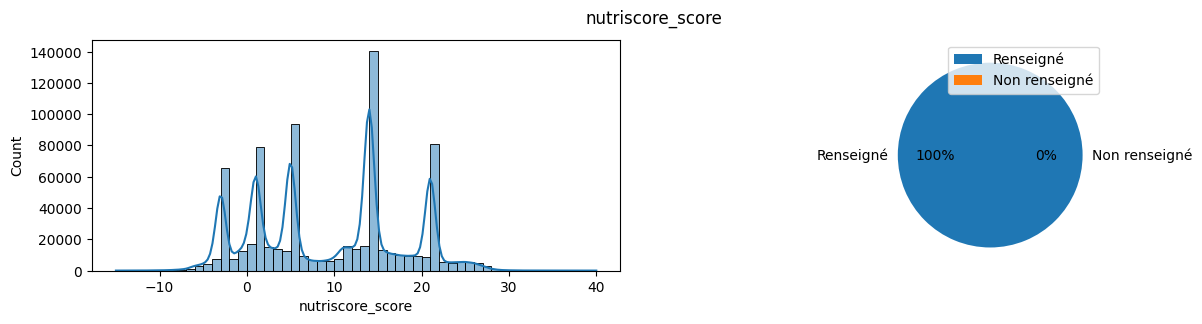

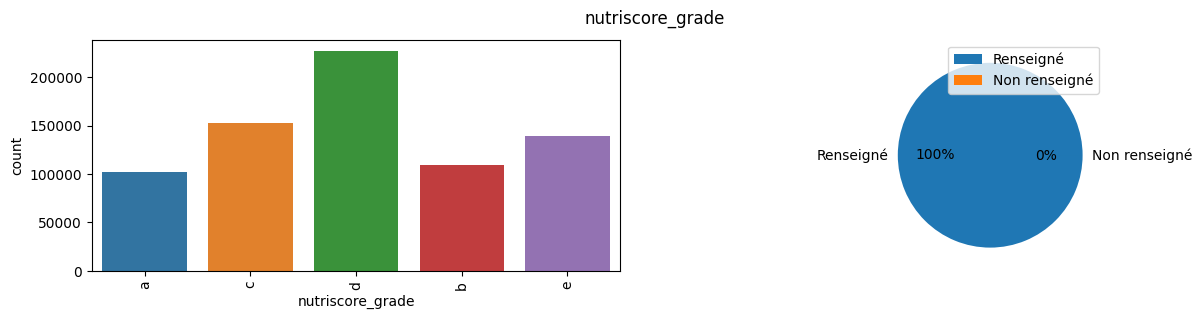

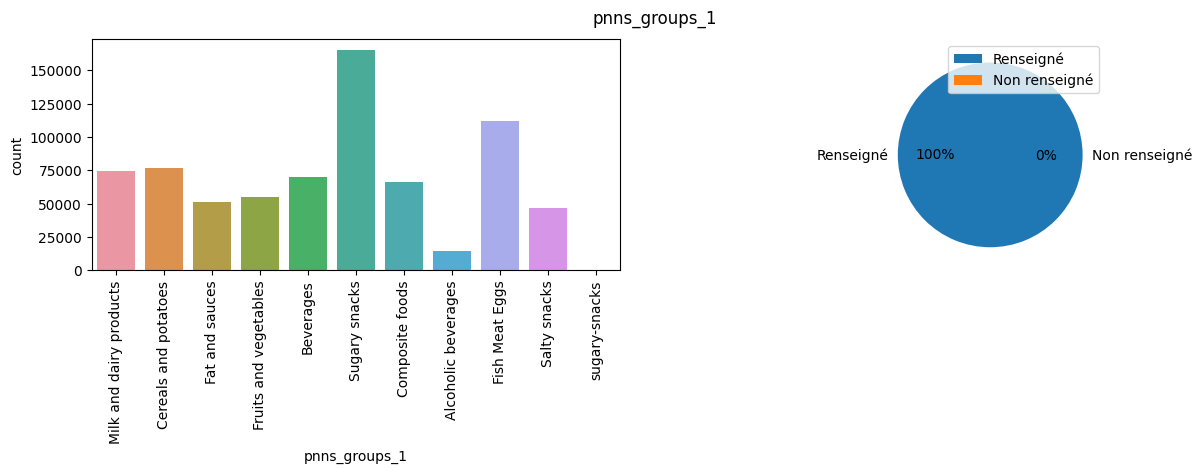

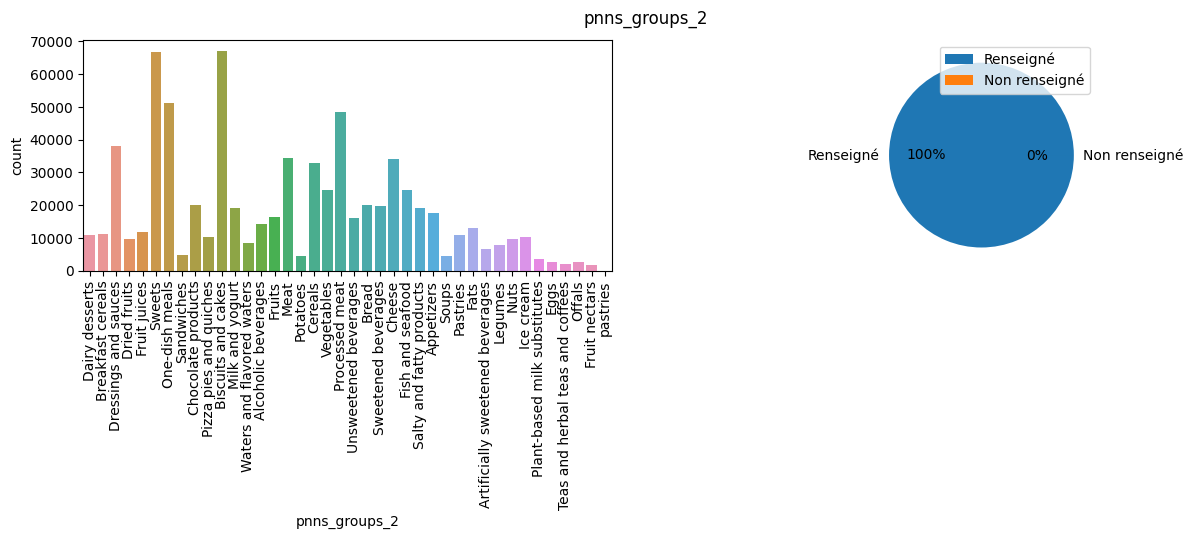

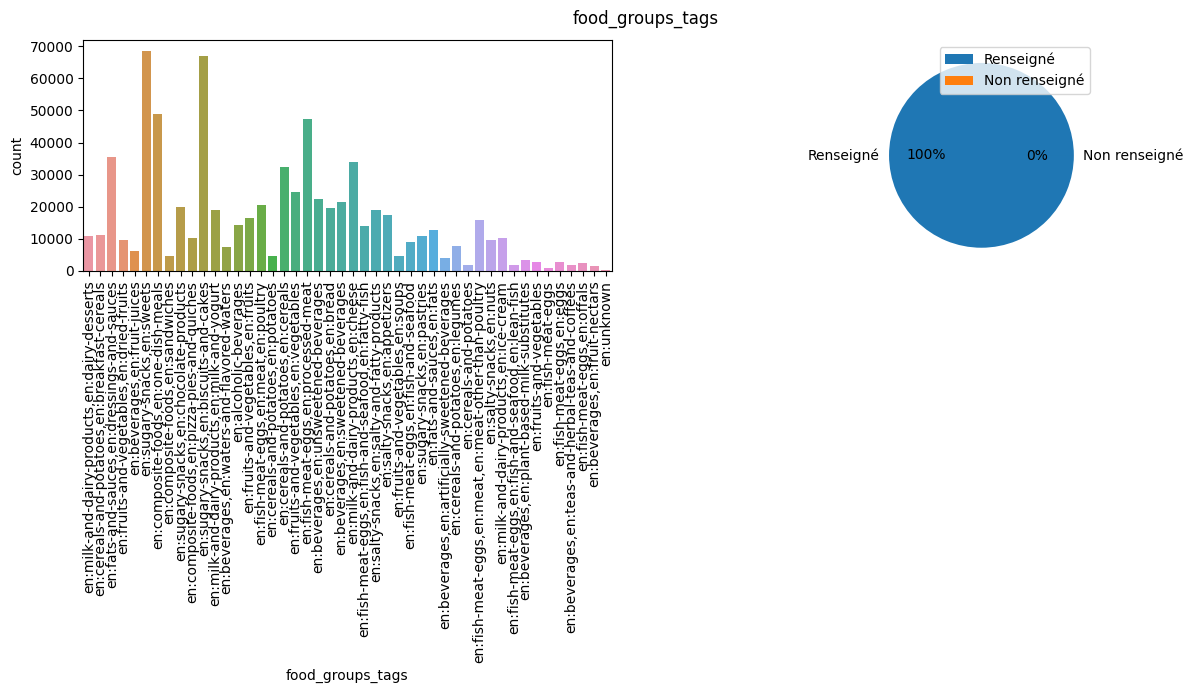

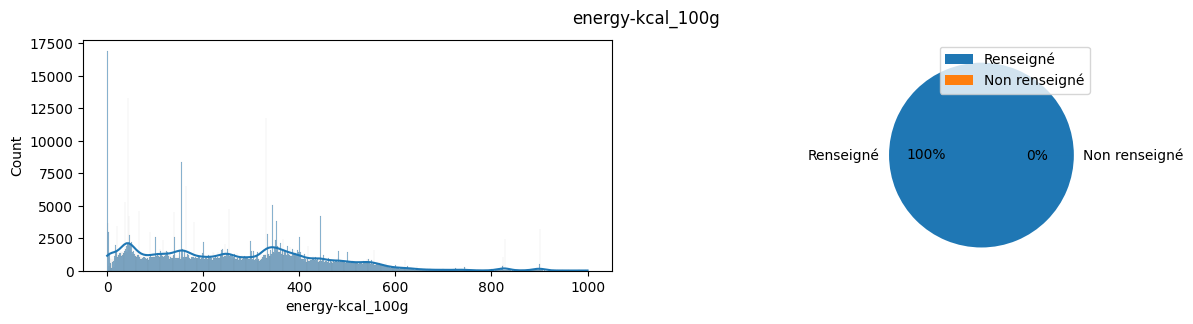

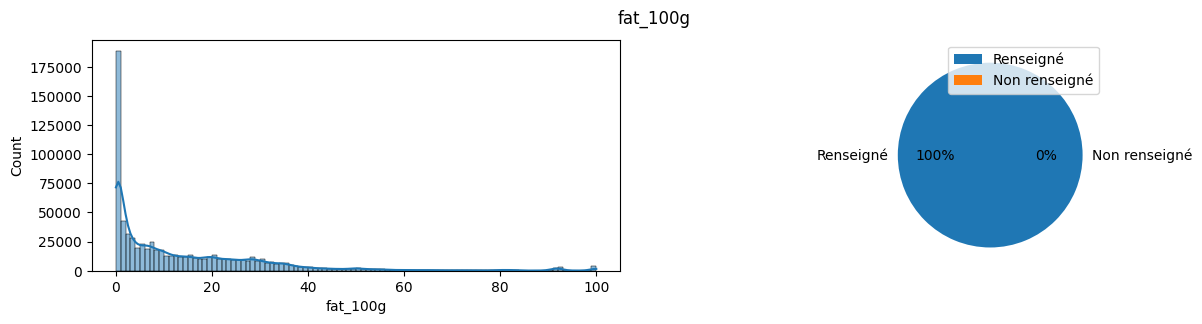

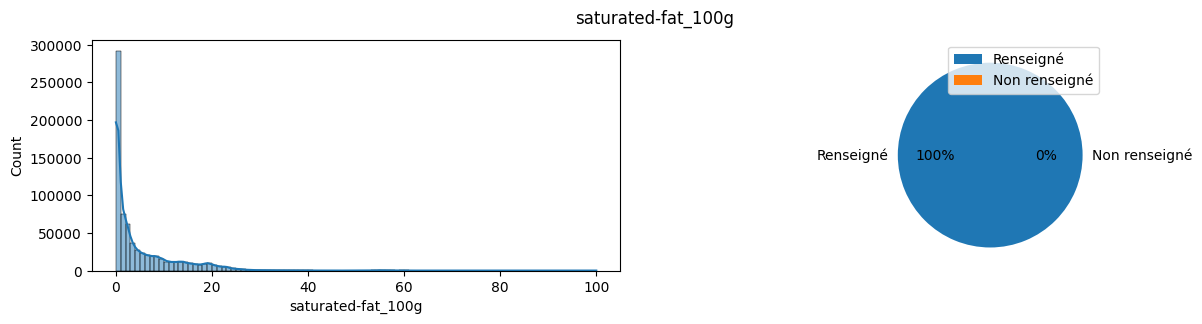

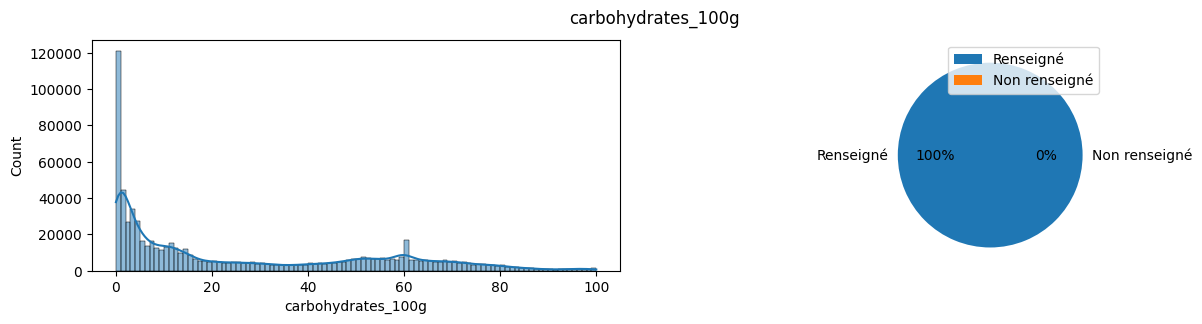

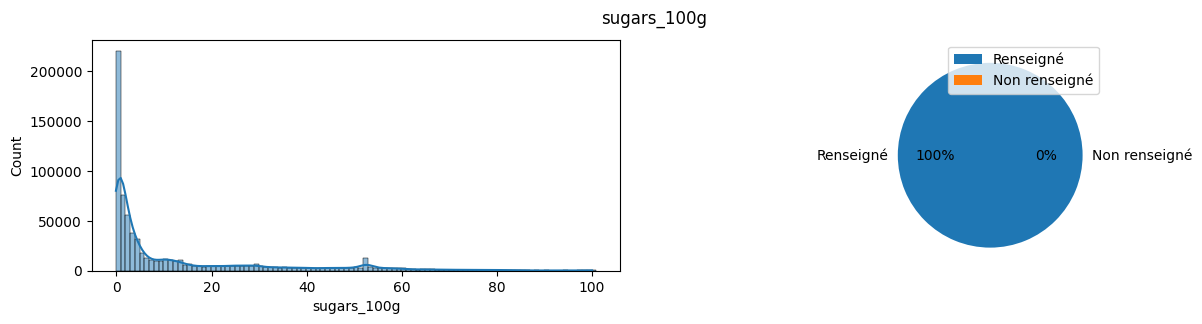

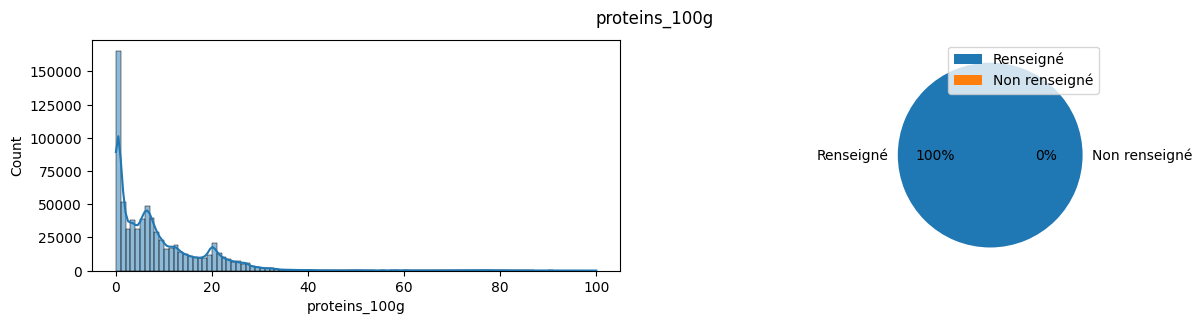

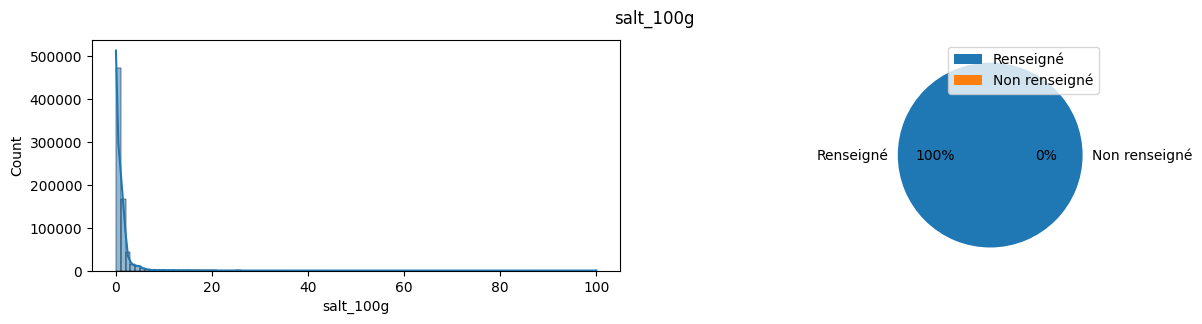

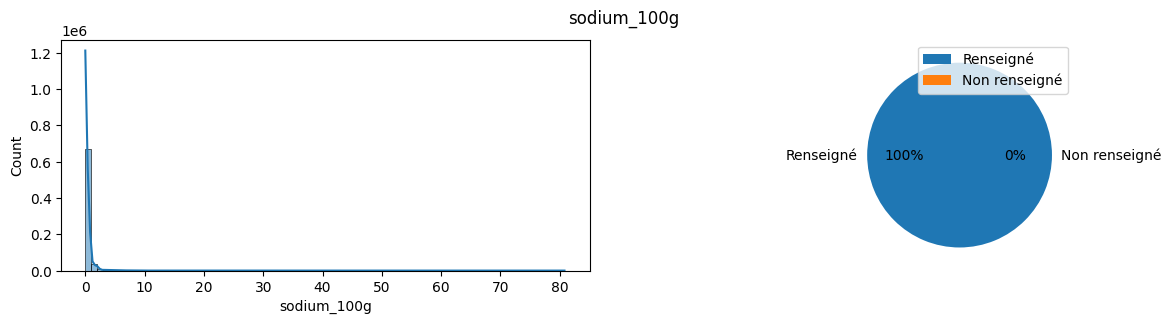

In [32]:
cols_to_view = [c for c in df.columns if c not in ["code", "product_name", "brands_tags"]]

for i in range(0, len(cols_to_view)):
    c = cols_to_view[i]
    f = plt.figure(figsize=(15,3))

    plt.subplot(1,2,1)
    if df[c].dtype=='O':
        g = sns.countplot(x=df[c])
        plt.xticks(rotation=90)
    else:
        sns.histplot(data=df, x=c, kde=True, binwidth=1)

    plt.subplot(1,2,2)

    f.suptitle(c)
    t_rep = {"Renseigné": df.loc[~df[c].isna()].shape[0], "Non renseigné": df.loc[df[c].isna()].shape[0]}
    plt.pie(list(t_rep.values()), labels=list(t_rep.keys()), autopct='%1.0f%%')
    plt.legend(loc=1)
    plt.show()
    

In [27]:
repartition = dict(zip(df.columns, [0] * len(df.columns)))
total_count_fr = df.shape[0]

for col in df.columns:
    repartition[col] += df.loc[~df[col].isna()].shape[0]
    
df_info = pd.DataFrame(
    {"column": repartition.keys(), "filled_nb": repartition.values()}
)
df_info["filled_ratio"] = round(100 * df_info["filled_nb"] / total_count_fr, 2)
df_info["dtype"] = df_info.apply(lambda x: df.dtypes[x["column"]], axis=1)

fig = px.bar(
    df_info,
    x="filled_ratio",
    y="column",
    orientation="h",
    color="dtype",
    color_discrete_sequence=px.colors.qualitative.G10,
    title="Répartition des variables par nombre d'observations renseignées et par type",
    labels={
        "column": "Nom de la colonne",
        "filled_ratio": "Taux de remplissage",
        "dtype": "Type de la variable",
    },
)
fig.update_layout(
    {
        "height": 500,
        "yaxis_categoryorder": "total ascending",
    }
)
fig.update_yaxes(tickfont={"size": 9})

In [33]:
df.drop(columns=["brands_tags"], inplace=True) #A voir si on garde 

In [34]:
df.query("&".join(map(lambda x: f""" `{x}`.notnull() """, list(df.columns)))).reset_index(drop=True).to_parquet(f"{working_dir}/fully_cleaned.parquet")